In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-18 23:03:10,439] A new study created in memory with name: no-name-de0ea811-ff52-46dd-beb9-f874000555d2
[I 2025-05-18 23:11:17,064] Trial 0 finished with value: 0.04606150835752487 and parameters: {'lr': 0.06965223912783648, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11242649723693039}. Best is trial 0 with value: 0.04606150835752487.


Cross Validation Accuracies:
[0.046701397746801376, 0.03808491304516792, 0.04089872166514397, 0.055226124823093414, 0.04939638450741768]
Mean Cross Validation Accuracy:
0.04606150835752487
Standard Deviation of Cross Validation Accuracy:
0.0060959247294359335


[I 2025-05-18 23:21:57,932] Trial 1 finished with value: 0.13158746659755707 and parameters: {'lr': 0.00209886967595999, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.31006282036890087}. Best is trial 0 with value: 0.04606150835752487.


Cross Validation Accuracies:
[0.12967932224273682, 0.13260772824287415, 0.12569104135036469, 0.13357201218605042, 0.13638722896575928]
Mean Cross Validation Accuracy:
0.13158746659755707
Standard Deviation of Cross Validation Accuracy:
0.0036448846177481046


[I 2025-05-18 23:29:53,636] Trial 2 finished with value: 0.0354788601398468 and parameters: {'lr': 0.0020623650053925133, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30019962348598855}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[0.04578680917620659, 0.026377694681286812, 0.03737577050924301, 0.04841583967208862, 0.019438186660408974]
Mean Cross Validation Accuracy:
0.0354788601398468
Standard Deviation of Cross Validation Accuracy:
0.011111722999439673


[I 2025-05-18 23:37:09,200] Trial 3 finished with value: 1.1420365035533906 and parameters: {'lr': 0.35749399469288645, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.25461090987087936}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[2.3562848567962646, 0.9974091053009033, 0.590663731098175, 0.45615318417549133, 1.3096716403961182]
Mean Cross Validation Accuracy:
1.1420365035533906
Standard Deviation of Cross Validation Accuracy:
0.6779182176027416


[I 2025-05-18 23:45:24,407] Trial 4 finished with value: 0.31543700098991395 and parameters: {'lr': 0.02042101409931453, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17194812458281428}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[0.14290361106395721, 0.13481488823890686, 0.18612541258335114, 0.24528855085372925, 0.8680525422096252]
Mean Cross Validation Accuracy:
0.31543700098991395
Standard Deviation of Cross Validation Accuracy:
0.2790764578405966


[I 2025-05-18 23:55:18,935] Trial 5 finished with value: 0.11254371851682662 and parameters: {'lr': 0.225084453368457, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.49326774943042706}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[0.11693613231182098, 0.10784261673688889, 0.10933352261781693, 0.1199277713894844, 0.10867854952812195]
Mean Cross Validation Accuracy:
0.11254371851682662
Standard Deviation of Cross Validation Accuracy:
0.004922657468060502


[I 2025-05-19 00:04:27,609] Trial 6 finished with value: 0.04412377402186394 and parameters: {'lr': 0.021486772903192602, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15788058141711928}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[0.045543231070041656, 0.0397292822599411, 0.045361604541540146, 0.04940222203731537, 0.040582530200481415]
Mean Cross Validation Accuracy:
0.04412377402186394
Standard Deviation of Cross Validation Accuracy:
0.0035569948497846888


[I 2025-05-19 00:13:27,045] Trial 7 finished with value: 0.0921833261847496 and parameters: {'lr': 0.0025482458091003585, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.37934535117264}. Best is trial 2 with value: 0.0354788601398468.


Cross Validation Accuracies:
[0.08558626472949982, 0.09327372908592224, 0.08411088585853577, 0.1100580170750618, 0.0878877341747284]
Mean Cross Validation Accuracy:
0.0921833261847496
Standard Deviation of Cross Validation Accuracy:
0.00946394395896636


[I 2025-05-19 00:21:12,813] Trial 8 finished with value: 0.031260721012949945 and parameters: {'lr': 0.006358608015915876, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10178151444827171}. Best is trial 8 with value: 0.031260721012949945.


Cross Validation Accuracies:
[0.026700513437390327, 0.03200482204556465, 0.028638672083616257, 0.03408058360219002, 0.034879013895988464]
Mean Cross Validation Accuracy:
0.031260721012949945
Standard Deviation of Cross Validation Accuracy:
0.0031390440734845528


[I 2025-05-19 00:29:19,138] Trial 9 finished with value: 0.35812210440635683 and parameters: {'lr': 0.674103538279972, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32151372803083567}. Best is trial 8 with value: 0.031260721012949945.


Cross Validation Accuracies:
[0.3582138419151306, 0.3566572964191437, 0.3559821546077728, 0.3581509590148926, 0.36160627007484436]
Mean Cross Validation Accuracy:
0.35812210440635683
Standard Deviation of Cross Validation Accuracy:
0.0019428693391105895


[I 2025-05-19 00:37:58,983] Trial 10 finished with value: 0.027340547740459444 and parameters: {'lr': 0.00774823344857281, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21791372208881887}. Best is trial 10 with value: 0.027340547740459444.


Cross Validation Accuracies:
[0.025438906624913216, 0.024838926270604134, 0.03362857177853584, 0.03336048498749733, 0.01943584904074669]
Mean Cross Validation Accuracy:
0.027340547740459444
Standard Deviation of Cross Validation Accuracy:
0.005443114939181758


[I 2025-05-19 00:44:30,276] Trial 11 finished with value: 0.026484955847263337 and parameters: {'lr': 0.00774323048311999, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21215928183027455}. Best is trial 11 with value: 0.026484955847263337.


Cross Validation Accuracies:
[0.017869649454951286, 0.023845218122005463, 0.028598519042134285, 0.03407948836684227, 0.028031904250383377]
Mean Cross Validation Accuracy:
0.026484955847263337
Standard Deviation of Cross Validation Accuracy:
0.005398682106276182


[I 2025-05-19 00:51:11,495] Trial 12 finished with value: 0.026020937785506248 and parameters: {'lr': 0.0076076116225267, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22678813886598315}. Best is trial 12 with value: 0.026020937785506248.


Cross Validation Accuracies:
[0.018363311886787415, 0.026012681424617767, 0.029736094176769257, 0.03525432199239731, 0.020738279446959496]
Mean Cross Validation Accuracy:
0.026020937785506248
Standard Deviation of Cross Validation Accuracy:
0.006092676794605959


[I 2025-05-19 00:58:42,096] Trial 13 finished with value: 0.02885495834052563 and parameters: {'lr': 0.007088151848888469, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21844262313370671}. Best is trial 12 with value: 0.026020937785506248.


Cross Validation Accuracies:
[0.019562754780054092, 0.02654900960624218, 0.033465251326560974, 0.03710488602519035, 0.027592889964580536]
Mean Cross Validation Accuracy:
0.02885495834052563
Standard Deviation of Cross Validation Accuracy:
0.006042704218795228


[I 2025-05-19 01:04:40,457] Trial 14 finished with value: 0.025305261462926866 and parameters: {'lr': 0.07244726013752932, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4064411221786798}. Best is trial 14 with value: 0.025305261462926866.


Cross Validation Accuracies:
[0.018013615161180496, 0.024216623976826668, 0.028627874329686165, 0.03550242260098457, 0.02016577124595642]
Mean Cross Validation Accuracy:
0.025305261462926866
Standard Deviation of Cross Validation Accuracy:
0.006257626524395935


[I 2025-05-19 01:10:37,834] Trial 15 finished with value: 0.024688892439007758 and parameters: {'lr': 0.05364800616474516, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40259671093433513}. Best is trial 15 with value: 0.024688892439007758.


Cross Validation Accuracies:
[0.017863087356090546, 0.02359156124293804, 0.02906801551580429, 0.03357866778969765, 0.01934313029050827]
Mean Cross Validation Accuracy:
0.024688892439007758
Standard Deviation of Cross Validation Accuracy:
0.005908938118471737


[I 2025-05-19 01:17:03,843] Trial 16 finished with value: 0.02559812143445015 and parameters: {'lr': 0.07829359270717276, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.43053077392078815}. Best is trial 15 with value: 0.024688892439007758.


Cross Validation Accuracies:
[0.021370314061641693, 0.02424452267587185, 0.029830249026417732, 0.03321675956249237, 0.019328761845827103]
Mean Cross Validation Accuracy:
0.02559812143445015
Standard Deviation of Cross Validation Accuracy:
0.0051954981534595894


[I 2025-05-19 01:23:06,243] Trial 17 finished with value: 0.024626676738262177 and parameters: {'lr': 0.07108503173281897, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3956783881558893}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.017890051007270813, 0.02325102873146534, 0.02873082272708416, 0.03318009153008461, 0.02008138969540596]
Mean Cross Validation Accuracy:
0.024626676738262177
Standard Deviation of Cross Validation Accuracy:
0.005620304028761185


[I 2025-05-19 01:30:14,082] Trial 18 finished with value: 0.7349126875400543 and parameters: {'lr': 0.1366316115842853, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4758922833080763}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.49771949648857117, 0.49795249104499817, 0.45809662342071533, 1.7945736646652222, 0.42622116208076477]
Mean Cross Validation Accuracy:
0.7349126875400543
Standard Deviation of Cross Validation Accuracy:
0.5305110219950065


[I 2025-05-19 01:38:19,625] Trial 19 finished with value: 0.04589064046740532 and parameters: {'lr': 0.04422403966632725, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3672973122741029}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.04432402178645134, 0.03966013342142105, 0.04884078726172447, 0.05182190239429474, 0.044806357473134995]
Mean Cross Validation Accuracy:
0.04589064046740532
Standard Deviation of Cross Validation Accuracy:
0.004155295799498202


[I 2025-05-19 01:44:10,925] Trial 20 finished with value: 0.08756119087338447 and parameters: {'lr': 0.9077034721917676, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45609065246577374}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.10793276131153107, 0.05727088078856468, 0.11403214931488037, 0.09233932942152023, 0.06623083353042603]
Mean Cross Validation Accuracy:
0.08756119087338447
Standard Deviation of Cross Validation Accuracy:
0.02240995386129025


[I 2025-05-19 01:52:10,541] Trial 21 finished with value: 0.026459082216024398 and parameters: {'lr': 0.11577421665389845, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3916774429781403}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.0211650300770998, 0.026601223275065422, 0.02871972881257534, 0.034236229956150055, 0.021573198959231377]
Mean Cross Validation Accuracy:
0.026459082216024398
Standard Deviation of Cross Validation Accuracy:
0.004847960340917957


[I 2025-05-19 01:58:42,851] Trial 22 finished with value: 0.02485235296189785 and parameters: {'lr': 0.03533861435059715, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4121969202842578}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.017957644537091255, 0.02443087287247181, 0.029229404404759407, 0.03364749252796173, 0.018996350467205048]
Mean Cross Validation Accuracy:
0.02485235296189785
Standard Deviation of Cross Validation Accuracy:
0.005975290357241709


[I 2025-05-19 02:05:23,511] Trial 23 finished with value: 0.025304262712597846 and parameters: {'lr': 0.03120336691972112, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3509934898782632}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.01803654432296753, 0.02327110804617405, 0.028661012649536133, 0.034708116203546524, 0.021844532340765]
Mean Cross Validation Accuracy:
0.025304262712597846
Standard Deviation of Cross Validation Accuracy:
0.005807295641737504


[I 2025-05-19 02:12:09,081] Trial 24 finished with value: 0.025743775069713593 and parameters: {'lr': 0.016555352133805625, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4181633878439523}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.017859436571598053, 0.02444363944232464, 0.029953306540846825, 0.03431618586182594, 0.022146306931972504]
Mean Cross Validation Accuracy:
0.025743775069713593
Standard Deviation of Cross Validation Accuracy:
0.005796573215266424


[I 2025-05-19 02:18:44,140] Trial 25 finished with value: 0.02496507279574871 and parameters: {'lr': 0.043282276498639055, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45211609405911385}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018112724646925926, 0.023231597617268562, 0.028834374621510506, 0.03354111686348915, 0.021105550229549408]
Mean Cross Validation Accuracy:
0.02496507279574871
Standard Deviation of Cross Validation Accuracy:
0.005538511609751361


[I 2025-05-19 02:25:24,556] Trial 26 finished with value: 0.03424105271697044 and parameters: {'lr': 0.2222903945226422, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3421068409838289}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.043588899075984955, 0.0235735010355711, 0.03371971473097801, 0.040947891771793365, 0.029375256970524788]
Mean Cross Validation Accuracy:
0.03424105271697044
Standard Deviation of Cross Validation Accuracy:
0.007349943429389537


[I 2025-05-19 02:32:11,180] Trial 27 finished with value: 0.026612019911408425 and parameters: {'lr': 0.03255825500397222, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.26455559627656544}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.01795698143541813, 0.029071776196360588, 0.029560236260294914, 0.03332013636827469, 0.023150969296693802]
Mean Cross Validation Accuracy:
0.026612019911408425
Standard Deviation of Cross Validation Accuracy:
0.005415344299277233


[I 2025-05-19 02:39:16,534] Trial 28 finished with value: 0.032952380180358884 and parameters: {'lr': 0.013278497765023845, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4343086728422735}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.027986200526356697, 0.023823795840144157, 0.044250309467315674, 0.03839762136340141, 0.030303973704576492]
Mean Cross Validation Accuracy:
0.032952380180358884
Standard Deviation of Cross Validation Accuracy:
0.007379727731939482


[I 2025-05-19 02:48:54,522] Trial 29 finished with value: 3.2263131618499754 and parameters: {'lr': 0.12679542002585847, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3985282020161722}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[2.9666974544525146, 3.9639666080474854, 3.105098009109497, 3.231281280517578, 2.8645224571228027]
Mean Cross Validation Accuracy:
3.2263131618499754
Standard Deviation of Cross Validation Accuracy:
0.3891383383061925


[I 2025-05-19 02:55:36,738] Trial 30 finished with value: 0.029437658563256263 and parameters: {'lr': 0.044377902068240195, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.33666398932746505}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018309637904167175, 0.026949910447001457, 0.0304668378084898, 0.04035937041044235, 0.031102536246180534]
Mean Cross Validation Accuracy:
0.029437658563256263
Standard Deviation of Cross Validation Accuracy:
0.007115287088655336


[I 2025-05-19 03:02:09,409] Trial 31 finished with value: 0.02571755275130272 and parameters: {'lr': 0.046861835541829176, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45642065614684135}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018288714811205864, 0.023908911272883415, 0.029452325776219368, 0.034067075699567795, 0.022870736196637154]
Mean Cross Validation Accuracy:
0.02571755275130272
Standard Deviation of Cross Validation Accuracy:
0.005481354661848644


[I 2025-05-19 03:09:13,173] Trial 32 finished with value: 0.02526383101940155 and parameters: {'lr': 0.0819496211734711, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.44739631729895357}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.01807694509625435, 0.023613929748535156, 0.029087482020258904, 0.03317566215991974, 0.022365136072039604]
Mean Cross Validation Accuracy:
0.02526383101940155
Standard Deviation of Cross Validation Accuracy:
0.00529137628308988


[I 2025-05-19 03:16:28,170] Trial 33 finished with value: 0.025566944479942323 and parameters: {'lr': 0.02906102115246728, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4944883054692747}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.019605590030550957, 0.023437203839421272, 0.03053656406700611, 0.03375444561243057, 0.020500918850302696]
Mean Cross Validation Accuracy:
0.025566944479942323
Standard Deviation of Cross Validation Accuracy:
0.005611959575441635


[I 2025-05-19 03:23:44,045] Trial 34 finished with value: 0.026122963055968285 and parameters: {'lr': 0.05663260629605612, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3693551667468404}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.023955686017870903, 0.02383059449493885, 0.02965557761490345, 0.033250272274017334, 0.019922684878110886]
Mean Cross Validation Accuracy:
0.026122963055968285
Standard Deviation of Cross Validation Accuracy:
0.004725958001801595


[I 2025-05-19 03:32:44,723] Trial 35 finished with value: 0.03079448491334915 and parameters: {'lr': 0.012631710078849777, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2821673657618745}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.032257746905088425, 0.024005871266126633, 0.02860424667596817, 0.0350872278213501, 0.03401733189821243]
Mean Cross Validation Accuracy:
0.03079448491334915
Standard Deviation of Cross Validation Accuracy:
0.004045687551115265


[I 2025-05-19 03:41:42,254] Trial 36 finished with value: 4.729515910148621 and parameters: {'lr': 0.20045761018370112, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4759125296933239}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[1.265476107597351, 5.363231658935547, 3.3717172145843506, 10.619538307189941, 3.027616262435913]
Mean Cross Validation Accuracy:
4.729515910148621
Standard Deviation of Cross Validation Accuracy:
3.2197394599603575


[I 2025-05-19 03:48:19,191] Trial 37 finished with value: 0.02462966963648796 and parameters: {'lr': 0.09898214174902467, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4075853813625706}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.01818900927901268, 0.02326112799346447, 0.029131708666682243, 0.03340835124254227, 0.019158151000738144]
Mean Cross Validation Accuracy:
0.02462966963648796
Standard Deviation of Cross Validation Accuracy:
0.005841680142223972


[I 2025-05-19 03:55:27,478] Trial 38 finished with value: 0.6479797840118409 and parameters: {'lr': 0.10264547672421967, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.312749632012887}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.4228481948375702, 1.3879042863845825, 0.3655010461807251, 0.7556371092796326, 0.3080082833766937]
Mean Cross Validation Accuracy:
0.6479797840118409
Standard Deviation of Cross Validation Accuracy:
0.4012823095802433


[I 2025-05-19 04:04:34,876] Trial 39 finished with value: 55.61453552246094 and parameters: {'lr': 0.49492082456738334, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3845933726302948}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[61.8927001953125, 61.91555404663086, 48.116477966308594, 49.74308776855469, 56.40485763549805]
Mean Cross Validation Accuracy:
55.61453552246094
Standard Deviation of Cross Validation Accuracy:
5.838451181365711


[I 2025-05-19 04:11:27,705] Trial 40 finished with value: 0.0884128525853157 and parameters: {'lr': 0.18469054393485154, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.41736722031963364}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.0873471051454544, 0.08757887780666351, 0.09029795974493027, 0.08944588899612427, 0.08739443123340607]
Mean Cross Validation Accuracy:
0.0884128525853157
Standard Deviation of Cross Validation Accuracy:
0.0012238714651719483


[I 2025-05-19 04:18:37,741] Trial 41 finished with value: 0.025258255004882813 and parameters: {'lr': 0.023437451038569774, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4397482610081031}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.01896902173757553, 0.024305183440446854, 0.029500460252165794, 0.03369736298918724, 0.019819246605038643]
Mean Cross Validation Accuracy:
0.025258255004882813
Standard Deviation of Cross Validation Accuracy:
0.005643765796025602


[I 2025-05-19 04:24:44,008] Trial 42 finished with value: 0.033565185591578485 and parameters: {'lr': 0.3494847459114769, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.46933145619249456}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.0220717191696167, 0.024063559249043465, 0.03825388103723526, 0.04315557703375816, 0.04028119146823883]
Mean Cross Validation Accuracy:
0.033565185591578485
Standard Deviation of Cross Validation Accuracy:
0.008734356089347521


[I 2025-05-19 04:31:09,520] Trial 43 finished with value: 0.024882353097200393 and parameters: {'lr': 0.059245575388259676, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.41424566055671225}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018055913969874382, 0.024647144600749016, 0.029485590755939484, 0.03316156938672066, 0.01906154677271843]
Mean Cross Validation Accuracy:
0.024882353097200393
Standard Deviation of Cross Validation Accuracy:
0.0058356250697677815


[I 2025-05-19 04:37:48,186] Trial 44 finished with value: 0.025067845359444618 and parameters: {'lr': 0.0638093418844307, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.361511252943174}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018098779022693634, 0.024017460644245148, 0.03058561496436596, 0.03349348157644272, 0.01914389058947563]
Mean Cross Validation Accuracy:
0.025067845359444618
Standard Deviation of Cross Validation Accuracy:
0.00610248409824692


[I 2025-05-19 04:45:06,713] Trial 45 finished with value: 0.027914287894964217 and parameters: {'lr': 0.3041064857990495, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.404217824967367}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.024724213406443596, 0.023233484476804733, 0.030696270987391472, 0.03329242765903473, 0.02762504294514656]
Mean Cross Validation Accuracy:
0.027914287894964217
Standard Deviation of Cross Validation Accuracy:
0.003710363210554626


[I 2025-05-19 04:52:53,346] Trial 46 finished with value: 0.028074705228209495 and parameters: {'lr': 0.16423638517211317, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.41482483669290515}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.018194785341620445, 0.033089738339185715, 0.03455283120274544, 0.033467188477516174, 0.021068982779979706]
Mean Cross Validation Accuracy:
0.028074705228209495
Standard Deviation of Cross Validation Accuracy:
0.006969770625024138


[I 2025-05-19 05:00:22,446] Trial 47 finished with value: 0.10511486232280731 and parameters: {'lr': 0.10072859695412004, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14116661531626165}. Best is trial 17 with value: 0.024626676738262177.


Cross Validation Accuracies:
[0.09519103169441223, 0.10650085657835007, 0.1123887374997139, 0.10906995087862015, 0.10242373496294022]
Mean Cross Validation Accuracy:
0.10511486232280731
Standard Deviation of Cross Validation Accuracy:
0.005936287500753893


[I 2025-05-19 05:08:07,507] Trial 48 finished with value: 0.02244227398186922 and parameters: {'lr': 0.0014124953595466543, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.38236140714044003}. Best is trial 48 with value: 0.02244227398186922.


Cross Validation Accuracies:
[0.015508273616433144, 0.03226605802774429, 0.027925686910748482, 0.024025587365031242, 0.012485763989388943]
Mean Cross Validation Accuracy:
0.02244227398186922
Standard Deviation of Cross Validation Accuracy:
0.007433624740274653


[I 2025-05-19 05:15:22,700] Trial 49 finished with value: 0.02376519050449133 and parameters: {'lr': 0.002923387911833537, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3296827617844302}. Best is trial 48 with value: 0.02244227398186922.


Cross Validation Accuracies:
[0.015217513777315617, 0.029339535161852837, 0.026363695040345192, 0.02071209065616131, 0.027193117886781693]
Mean Cross Validation Accuracy:
0.02376519050449133
Standard Deviation of Cross Validation Accuracy:
0.005137322774292814


[I 2025-05-19 05:22:47,863] Trial 50 finished with value: 0.019730005785822867 and parameters: {'lr': 0.0010911036711205796, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32367765042055896}. Best is trial 50 with value: 0.019730005785822867.


Cross Validation Accuracies:
[0.017864717170596123, 0.01776665449142456, 0.023214442655444145, 0.02085305005311966, 0.018951164558529854]
Mean Cross Validation Accuracy:
0.019730005785822867
Standard Deviation of Cross Validation Accuracy:
0.002066067390252584


[I 2025-05-19 05:31:22,034] Trial 51 finished with value: 0.018819351494312287 and parameters: {'lr': 0.0010091492823513571, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33140728211980425}. Best is trial 51 with value: 0.018819351494312287.


Cross Validation Accuracies:
[0.014982474036514759, 0.02093045599758625, 0.02062179706990719, 0.023092301562428474, 0.01446972880512476]
Mean Cross Validation Accuracy:
0.018819351494312287
Standard Deviation of Cross Validation Accuracy:
0.003452666237150331


[I 2025-05-19 05:40:06,237] Trial 52 finished with value: 0.019577851332724095 and parameters: {'lr': 0.0012445827373316698, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29482672834774504}. Best is trial 51 with value: 0.018819351494312287.


Cross Validation Accuracies:
[0.01605113595724106, 0.01930486224591732, 0.021564705297350883, 0.027081303298473358, 0.013887249864637852]
Mean Cross Validation Accuracy:
0.019577851332724095
Standard Deviation of Cross Validation Accuracy:
0.004585729375548213


[I 2025-05-19 05:49:05,308] Trial 53 finished with value: 0.019469529390335083 and parameters: {'lr': 0.0011243314784050039, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2880853115703707}. Best is trial 51 with value: 0.018819351494312287.


Cross Validation Accuracies:
[0.015331309288740158, 0.016748536378145218, 0.02114246040582657, 0.023027243092656136, 0.021098097786307335]
Mean Cross Validation Accuracy:
0.019469529390335083
Standard Deviation of Cross Validation Accuracy:
0.0029201687818434865


[I 2025-05-19 05:58:05,387] Trial 54 finished with value: 0.019764087349176406 and parameters: {'lr': 0.0010163049430159435, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2911375770420584}. Best is trial 51 with value: 0.018819351494312287.


Cross Validation Accuracies:
[0.02192309871315956, 0.020702332258224487, 0.01846352033317089, 0.025044141337275505, 0.01268734410405159]
Mean Cross Validation Accuracy:
0.019764087349176406
Standard Deviation of Cross Validation Accuracy:
0.004127768724551933


[I 2025-05-19 06:06:32,835] Trial 55 finished with value: 0.018315843679010867 and parameters: {'lr': 0.001108797108673258, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29592704806377795}. Best is trial 55 with value: 0.018315843679010867.


Cross Validation Accuracies:
[0.016767172142863274, 0.020057324320077896, 0.020202215760946274, 0.020524373278021812, 0.014028132893145084]
Mean Cross Validation Accuracy:
0.018315843679010867
Standard Deviation of Cross Validation Accuracy:
0.002539748206201848


[I 2025-05-19 06:15:35,850] Trial 56 finished with value: 0.01789739355444908 and parameters: {'lr': 0.0011078707355090896, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28983113507900715}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.019416000694036484, 0.020998289808630943, 0.019559506326913834, 0.01950940303504467, 0.010003767907619476]
Mean Cross Validation Accuracy:
0.01789739355444908
Standard Deviation of Cross Validation Accuracy:
0.003989793090119125


[I 2025-05-19 06:26:37,084] Trial 57 finished with value: 0.026160740107297898 and parameters: {'lr': 0.003552145166549551, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25808889152664005}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.019823357462882996, 0.02669738605618477, 0.02880754880607128, 0.03358142077922821, 0.02189398743212223]
Mean Cross Validation Accuracy:
0.026160740107297898
Standard Deviation of Cross Validation Accuracy:
0.004913810821958233


[I 2025-05-19 06:36:48,033] Trial 58 finished with value: 0.10624074339866638 and parameters: {'lr': 0.001739723107002764, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23512569336344868}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.09963016957044601, 0.11547811329364777, 0.10271045565605164, 0.11353415995836258, 0.09985081851482391]
Mean Cross Validation Accuracy:
0.10624074339866638
Standard Deviation of Cross Validation Accuracy:
0.006863187096314894


[I 2025-05-19 06:46:02,918] Trial 59 finished with value: 0.01904146485030651 and parameters: {'lr': 0.0010007394276599344, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30223321672470965}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.014927550218999386, 0.020360369235277176, 0.024265743792057037, 0.022358739748597145, 0.01329492125660181]
Mean Cross Validation Accuracy:
0.01904146485030651
Standard Deviation of Cross Validation Accuracy:
0.0042422628126219004


[I 2025-05-19 06:53:43,556] Trial 60 finished with value: 0.023626020550727843 and parameters: {'lr': 0.004386378629111048, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2725579357688644}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01871318928897381, 0.02293655276298523, 0.02759256772696972, 0.030539222061634064, 0.0183485709130764]
Mean Cross Validation Accuracy:
0.023626020550727843
Standard Deviation of Cross Validation Accuracy:
0.0048164012114129


[I 2025-05-19 07:01:46,253] Trial 61 finished with value: 0.019913037493824958 and parameters: {'lr': 0.0010858476751379157, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29975813278709784}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01911960542201996, 0.017508193850517273, 0.023612970486283302, 0.018103299662470818, 0.021221118047833443]
Mean Cross Validation Accuracy:
0.019913037493824958
Standard Deviation of Cross Validation Accuracy:
0.0022400239866580646


[I 2025-05-19 07:08:58,589] Trial 62 finished with value: 0.023789684288203716 and parameters: {'lr': 0.0020277274023400163, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3161566225696281}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.020327916368842125, 0.02941700629889965, 0.02150064706802368, 0.033211544156074524, 0.0144913075491786]
Mean Cross Validation Accuracy:
0.023789684288203716
Standard Deviation of Cross Validation Accuracy:
0.006695095740698432


[I 2025-05-19 07:16:26,881] Trial 63 finished with value: 0.02004889491945505 and parameters: {'lr': 0.0013659101082461613, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2483160744898557}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01816963031888008, 0.020752785727381706, 0.018936175853013992, 0.02692965418100357, 0.015456228516995907]
Mean Cross Validation Accuracy:
0.02004889491945505
Standard Deviation of Cross Validation Accuracy:
0.0038393404154605008


[I 2025-05-19 07:25:04,829] Trial 64 finished with value: 0.02304743602871895 and parameters: {'lr': 0.001427173043795157, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2977551371073024}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01792072504758835, 0.024234555661678314, 0.029123550280928612, 0.022126365453004837, 0.02183198370039463]
Mean Cross Validation Accuracy:
0.02304743602871895
Standard Deviation of Cross Validation Accuracy:
0.0036588872155556636


[I 2025-05-19 07:33:49,578] Trial 65 finished with value: 0.02410191185772419 and parameters: {'lr': 0.0026596529880096426, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2831587697877162}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.017868736758828163, 0.020515894517302513, 0.02870011329650879, 0.03324923664331436, 0.020175578072667122]
Mean Cross Validation Accuracy:
0.02410191185772419
Standard Deviation of Cross Validation Accuracy:
0.005864215145706986


[I 2025-05-19 07:42:43,863] Trial 66 finished with value: 0.022127532586455344 and parameters: {'lr': 0.001941931036211487, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3258287932078667}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01788540743291378, 0.02325056865811348, 0.028691226616501808, 0.020555177703499794, 0.020255282521247864]
Mean Cross Validation Accuracy:
0.022127532586455344
Standard Deviation of Cross Validation Accuracy:
0.0036963910870265486


[I 2025-05-19 07:51:19,917] Trial 67 finished with value: 0.01818510629236698 and parameters: {'lr': 0.0012247975074565493, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.309458598921084}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.016193561255931854, 0.018222879618406296, 0.024230318143963814, 0.01916646584868431, 0.013112306594848633]
Mean Cross Validation Accuracy:
0.01818510629236698
Standard Deviation of Cross Validation Accuracy:
0.003666295900139918


[I 2025-05-19 07:59:43,281] Trial 68 finished with value: 0.022230812162160874 and parameters: {'lr': 0.0016260611935301945, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24401848210138072}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.018420716747641563, 0.02487746626138687, 0.029232291504740715, 0.019350755959749222, 0.019272830337285995]
Mean Cross Validation Accuracy:
0.022230812162160874
Standard Deviation of Cross Validation Accuracy:
0.004185372102420598


[I 2025-05-19 08:08:25,395] Trial 69 finished with value: 0.026225927844643594 and parameters: {'lr': 0.0023748528090528887, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3052759851462238}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.021830186247825623, 0.02001335471868515, 0.034242723137140274, 0.033980004489421844, 0.021063370630145073]
Mean Cross Validation Accuracy:
0.026225927844643594
Standard Deviation of Cross Validation Accuracy:
0.006464755484923464


[I 2025-05-19 08:19:39,799] Trial 70 finished with value: 0.0385256715118885 and parameters: {'lr': 0.0047648432315466095, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1876650173291577}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.025582946836948395, 0.048757538199424744, 0.043987952172756195, 0.036572474986314774, 0.03772744536399841]
Mean Cross Validation Accuracy:
0.0385256715118885
Standard Deviation of Cross Validation Accuracy:
0.007829353352501026


[I 2025-05-19 08:27:43,118] Trial 71 finished with value: 0.02024114429950714 and parameters: {'lr': 0.0011975949821575558, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2716015505516164}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.02044755592942238, 0.02013585716485977, 0.01819211058318615, 0.02792506106197834, 0.014505136758089066]
Mean Cross Validation Accuracy:
0.02024114429950714
Standard Deviation of Cross Validation Accuracy:
0.0043862646896897966


[I 2025-05-19 08:34:56,386] Trial 72 finished with value: 0.02114170491695404 and parameters: {'lr': 0.00104566082749169, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34195053373038514}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.015230328775942326, 0.029636425897479057, 0.02804418094456196, 0.019572174176573753, 0.013225414790213108]
Mean Cross Validation Accuracy:
0.02114170491695404
Standard Deviation of Cross Validation Accuracy:
0.006631438815897062


[I 2025-05-19 08:43:27,183] Trial 73 finished with value: 0.022119487263262273 and parameters: {'lr': 0.0012275527788092435, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.35322474650116814}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.020144399255514145, 0.020034607499837875, 0.023226739838719368, 0.033523332327604294, 0.013668357394635677]
Mean Cross Validation Accuracy:
0.022119487263262273
Standard Deviation of Cross Validation Accuracy:
0.006495274941679588


[I 2025-05-19 08:54:41,003] Trial 74 finished with value: 0.024856223538517953 and parameters: {'lr': 0.001664455966822693, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28547572721704273}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01825125142931938, 0.030243782326579094, 0.02347797341644764, 0.03385787457227707, 0.018450235947966576]
Mean Cross Validation Accuracy:
0.024856223538517953
Standard Deviation of Cross Validation Accuracy:
0.006270843930460517


[I 2025-05-19 09:06:09,055] Trial 75 finished with value: 0.025867768004536627 and parameters: {'lr': 0.0023329224652236793, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31828269796028885}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.018108008429408073, 0.027234427630901337, 0.02876668982207775, 0.034861739724874496, 0.020367974415421486]
Mean Cross Validation Accuracy:
0.025867768004536627
Standard Deviation of Cross Validation Accuracy:
0.006027016371828765


[I 2025-05-19 09:19:20,019] Trial 76 finished with value: 0.19519917964935302 and parameters: {'lr': 0.003099149150915309, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.304118916599049}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.19567228853702545, 0.1935114860534668, 0.1991669088602066, 0.20060625672340393, 0.18703895807266235]
Mean Cross Validation Accuracy:
0.19519917964935302
Standard Deviation of Cross Validation Accuracy:
0.0047883340620567755


[I 2025-05-19 09:30:00,076] Trial 77 finished with value: 0.020159081928431986 and parameters: {'lr': 0.0010005825037000475, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3327126946805286}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.023485571146011353, 0.01832178793847561, 0.026842081919312477, 0.021164752542972565, 0.010981216095387936]
Mean Cross Validation Accuracy:
0.020159081928431986
Standard Deviation of Cross Validation Accuracy:
0.0053730487292154355


[I 2025-05-19 09:40:50,597] Trial 78 finished with value: 0.024486852809786797 and parameters: {'lr': 0.0014483017989331294, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26936403466501624}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.018177034333348274, 0.023608798161149025, 0.02863597683608532, 0.032970499247312546, 0.01904195547103882]
Mean Cross Validation Accuracy:
0.024486852809786797
Standard Deviation of Cross Validation Accuracy:
0.005646577428206492


[I 2025-05-19 09:51:54,231] Trial 79 finished with value: 0.02453197855502367 and parameters: {'lr': 0.0018774193413051321, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.292426051897956}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01532051246613264, 0.027004756033420563, 0.021145489066839218, 0.03466222435235977, 0.024526910856366158]
Mean Cross Validation Accuracy:
0.02453197855502367
Standard Deviation of Cross Validation Accuracy:
0.006403998010837535


[I 2025-05-19 10:02:32,636] Trial 80 finished with value: 0.023557148873806 and parameters: {'lr': 0.0012286401416356184, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3516869429714512}. Best is trial 56 with value: 0.01789739355444908.


Cross Validation Accuracies:
[0.01922830007970333, 0.020994652062654495, 0.029943494126200676, 0.028042035177350044, 0.019577262923121452]
Mean Cross Validation Accuracy:
0.023557148873806
Standard Deviation of Cross Validation Accuracy:
0.004517619390969606


[I 2025-05-19 10:13:24,749] Trial 81 finished with value: 0.01703734528273344 and parameters: {'lr': 0.0010070430958316003, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28840183199671016}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015520330518484116, 0.01797584816813469, 0.018809670582413673, 0.022205613553524017, 0.010675263591110706]
Mean Cross Validation Accuracy:
0.01703734528273344
Standard Deviation of Cross Validation Accuracy:
0.003834327549870651


[I 2025-05-19 10:20:32,165] Trial 82 finished with value: 0.025288794189691544 and parameters: {'lr': 0.0015396794472930632, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3116672459116603}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.020220112055540085, 0.021204721182584763, 0.03140714019536972, 0.03431093320250511, 0.01930106431245804]
Mean Cross Validation Accuracy:
0.025288794189691544
Standard Deviation of Cross Validation Accuracy:
0.006277853935842882


[I 2025-05-19 10:26:38,619] Trial 83 finished with value: 0.023610110953450204 and parameters: {'lr': 0.002193099546740635, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2767935262509308}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.018260130658745766, 0.01719369925558567, 0.029304634779691696, 0.033380959182977676, 0.019911130890250206]
Mean Cross Validation Accuracy:
0.023610110953450204
Standard Deviation of Cross Validation Accuracy:
0.0065018790894673184


[I 2025-05-19 10:32:46,833] Trial 84 finished with value: 0.017953032068908213 and parameters: {'lr': 0.001195025212652453, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3228806820713381}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.013884141109883785, 0.018001820892095566, 0.02391919307410717, 0.022126158699393272, 0.01183384656906128]
Mean Cross Validation Accuracy:
0.017953032068908213
Standard Deviation of Cross Validation Accuracy:
0.004626288970249392


[I 2025-05-19 10:39:01,027] Trial 85 finished with value: 0.01899352204054594 and parameters: {'lr': 0.0012839979690889543, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26195604516620696}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015521508641541004, 0.020418502390384674, 0.026208920404314995, 0.021134186536073685, 0.011684492230415344]
Mean Cross Validation Accuracy:
0.01899352204054594
Standard Deviation of Cross Validation Accuracy:
0.004983006739629563


[I 2025-05-19 10:45:16,406] Trial 86 finished with value: 0.02160382252186537 and parameters: {'lr': 0.0017935438534426179, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25922029070453856}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015229606069624424, 0.021152449771761894, 0.03204971179366112, 0.027891941368579865, 0.01169540360569954]
Mean Cross Validation Accuracy:
0.02160382252186537
Standard Deviation of Cross Validation Accuracy:
0.007585093004925009


[I 2025-05-19 10:51:33,610] Trial 87 finished with value: 0.044023719429969785 and parameters: {'lr': 0.0012493730882526444, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22515518183309674}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.06347379088401794, 0.03685315325856209, 0.03449813276529312, 0.03769839182496071, 0.047595128417015076]
Mean Cross Validation Accuracy:
0.044023719429969785
Standard Deviation of Cross Validation Accuracy:
0.010707229628207469


[I 2025-05-19 10:56:18,942] Trial 88 finished with value: 0.026137514039874077 and parameters: {'lr': 0.003560827707436872, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21000042416550885}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.02068338915705681, 0.024979038164019585, 0.028606347739696503, 0.034096166491508484, 0.022322628647089005]
Mean Cross Validation Accuracy:
0.026137514039874077
Standard Deviation of Cross Validation Accuracy:
0.004797461491990811


[I 2025-05-19 11:02:41,165] Trial 89 finished with value: 0.022003217972815035 and parameters: {'lr': 0.0015682736345649238, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31009243316411506}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.020763376727700233, 0.023790864273905754, 0.028589172288775444, 0.023177040740847588, 0.013695635832846165]
Mean Cross Validation Accuracy:
0.022003217972815035
Standard Deviation of Cross Validation Accuracy:
0.00486829458364816


[I 2025-05-19 11:09:42,862] Trial 90 finished with value: 0.12959261536598204 and parameters: {'lr': 0.002110765529297812, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34073224659262663}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.12723992764949799, 0.12744423747062683, 0.12825822830200195, 0.12817810475826263, 0.13684257864952087]
Mean Cross Validation Accuracy:
0.12959261536598204
Standard Deviation of Cross Validation Accuracy:
0.003646753728484421


[I 2025-05-19 11:16:17,646] Trial 91 finished with value: 0.022283095866441727 and parameters: {'lr': 0.001266261732592953, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28820232645843785}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.025700069963932037, 0.021648745983839035, 0.022767413407564163, 0.023522382602095604, 0.017776867374777794]
Mean Cross Validation Accuracy:
0.022283095866441727
Standard Deviation of Cross Validation Accuracy:
0.0026136029564326753


[I 2025-05-19 11:22:59,192] Trial 92 finished with value: 0.02115343827754259 and parameters: {'lr': 0.0010211119481593766, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29470754483830847}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015648165717720985, 0.02343289740383625, 0.02853160910308361, 0.02596084587275982, 0.01219367329031229]
Mean Cross Validation Accuracy:
0.02115343827754259
Standard Deviation of Cross Validation Accuracy:
0.006218197825900735


[I 2025-05-19 11:29:08,072] Trial 93 finished with value: 0.020599036291241647 and parameters: {'lr': 0.0012737269210190227, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27866030753365895}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015426397323608398, 0.017298854887485504, 0.022749120369553566, 0.03316135331988335, 0.014359455555677414]
Mean Cross Validation Accuracy:
0.020599036291241647
Standard Deviation of Cross Validation Accuracy:
0.006913963112639693


[I 2025-05-19 11:35:01,619] Trial 94 finished with value: 0.021628591790795328 and parameters: {'lr': 0.0016034642205370996, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2649545063771772}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.018908187747001648, 0.022854654118418694, 0.021456683054566383, 0.025840409100055695, 0.01908302493393421]
Mean Cross Validation Accuracy:
0.021628591790795328
Standard Deviation of Cross Validation Accuracy:
0.002574983311620993


[I 2025-05-19 11:40:55,804] Trial 95 finished with value: 0.01894624102860689 and parameters: {'lr': 0.001169814799122072, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2498705881675582}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.016014747321605682, 0.017213275656104088, 0.02456551231443882, 0.023923359811306, 0.013014310039579868]
Mean Cross Validation Accuracy:
0.01894624102860689
Standard Deviation of Cross Validation Accuracy:
0.0045416417902765524


[I 2025-05-19 11:46:59,093] Trial 96 finished with value: 0.02432723604142666 and parameters: {'lr': 0.0025600661859302406, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24707233865881378}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.01816076785326004, 0.02357390709221363, 0.027803026139736176, 0.033370740711688995, 0.01872773841023445]
Mean Cross Validation Accuracy:
0.02432723604142666
Standard Deviation of Cross Validation Accuracy:
0.005723867602795921


[I 2025-05-19 11:52:28,729] Trial 97 finished with value: 0.024270173348486423 and parameters: {'lr': 0.0018618010196990806, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3215137958409793}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.02392854541540146, 0.02323322743177414, 0.028887927532196045, 0.033188920468091965, 0.01211224589496851]
Mean Cross Validation Accuracy:
0.024270173348486423
Standard Deviation of Cross Validation Accuracy:
0.007069297989595496


[I 2025-05-19 11:58:25,447] Trial 98 finished with value: 0.01717032752931118 and parameters: {'lr': 0.0014527422801980591, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23744351029409658}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.015695733949542046, 0.019503505900502205, 0.020222436636686325, 0.01803719252347946, 0.012392768636345863]
Mean Cross Validation Accuracy:
0.01717032752931118
Standard Deviation of Cross Validation Accuracy:
0.002846402692328639


[I 2025-05-19 12:03:23,656] Trial 99 finished with value: 0.033603673055768016 and parameters: {'lr': 0.0013982980572703801, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.20052455683243603}. Best is trial 81 with value: 0.01703734528273344.


Cross Validation Accuracies:
[0.03459127992391586, 0.034226223826408386, 0.028769327327609062, 0.04174524173140526, 0.028686292469501495]
Mean Cross Validation Accuracy:
0.033603673055768016
Standard Deviation of Cross Validation Accuracy:
0.0047999918278621035
Number of finished trials: 100
Best trial: {'lr': 0.0010070430958316003, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28840183199671016}
Best hyperparameters:  {'lr': 0.0010070430958316003, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28840183199671016}
Fold 1:
Epoch 1/100
84/84 [==============================] - 32s 199ms/step - loss: 0.2031 - val_loss: 0.0483
Epoch 2/100
84/84 [==============================] - 11s 127ms/step - loss: 0.0619 - val_loss: 0.0339
Epoch 3/100
84/84 [==============================] - 11s 126ms/step - loss: 0.0423 - val_loss: 0.0219
Epoch 4/100
84/84 [=============================

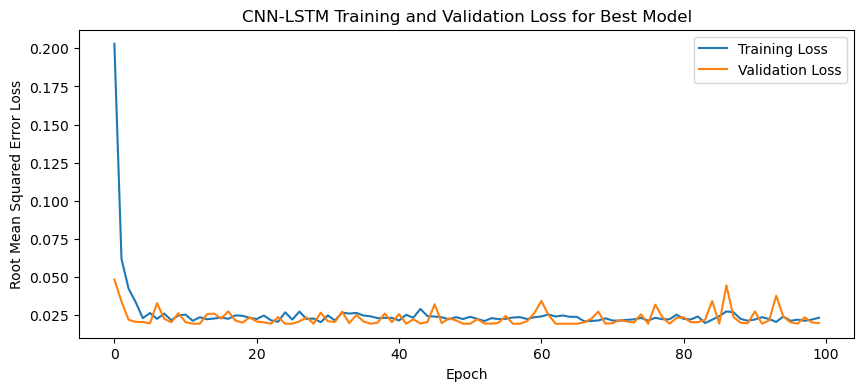

1/1 - 2s - loss: 0.0201 - 2s/epoch - 2s/step
Test Loss: 0.020114446058869362
1/1 [==============================] - 0s 30ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Specific Humidity\tPredicted Specific Humidity\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

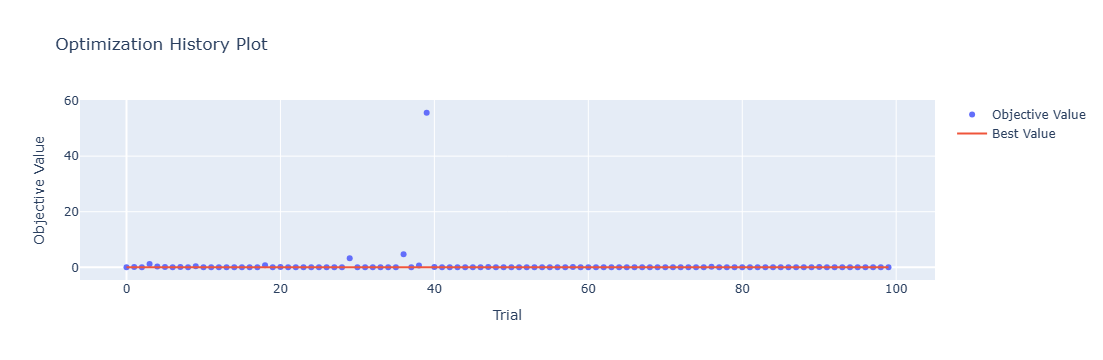

In [4]:
optuna.visualization.plot_optimization_history(study)

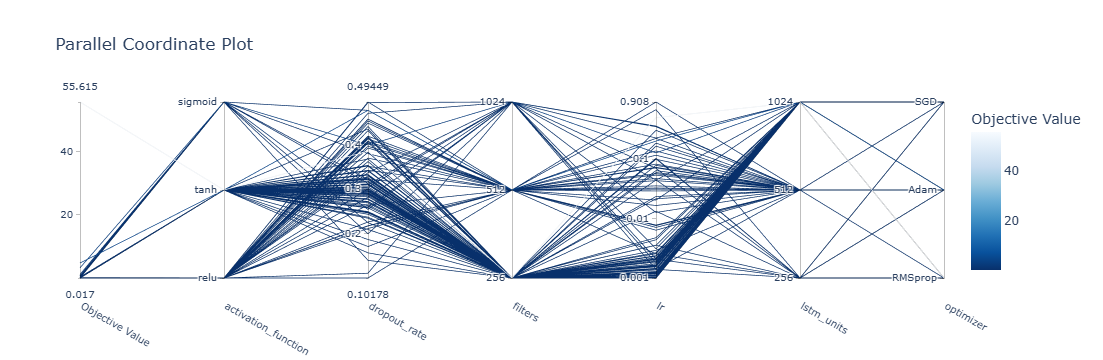

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

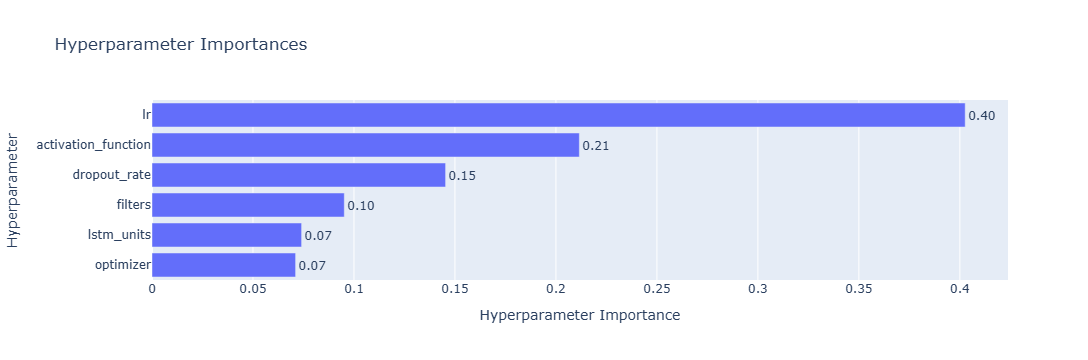

In [6]:
optuna.visualization.plot_param_importances(study)

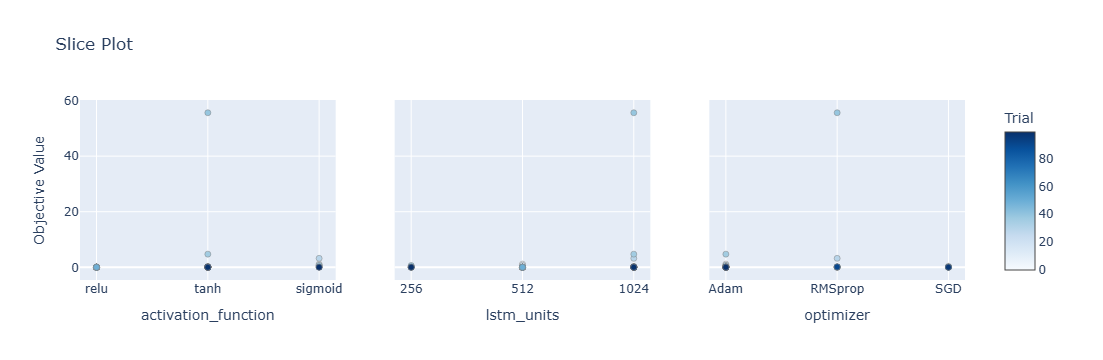

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

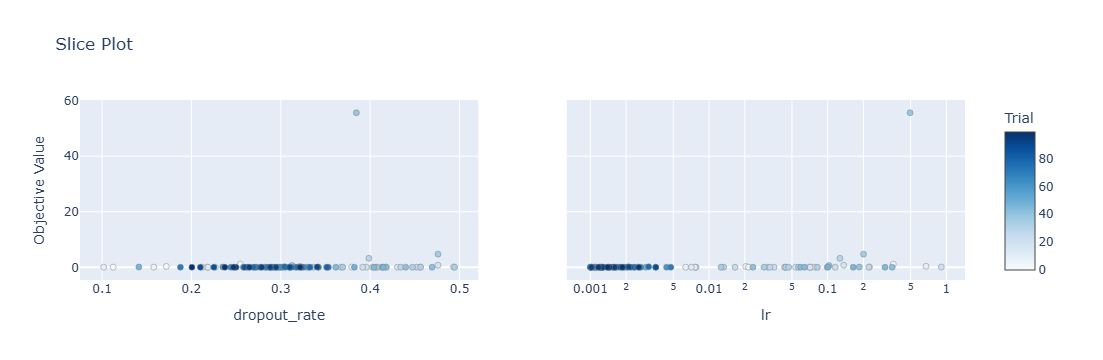

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 45s 330ms/step - loss: 0.1596 - accuracy: 0.0000e+00 - mae: 0.1596 - rmse: 0.1596 - mape: 32.0867 - pearson: nan - val_loss: 0.1977 - val_accuracy: 0.0000e+00 - val_mae: 0.1977 - val_rmse: 0.1977 - val_mape: 40.3968 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 21s 248ms/step - loss: 0.0745 - accuracy: 0.0000e+00 - mae: 0.0745 - rmse: 0.0745 - mape: 14.9503 - pearson: nan - val_loss: 0.0216 - val_accuracy: 0.0000e+00 - val_mae: 0.0216 - val_rmse: 0.0216 - val_mape: 4.5728 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 23s 273ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - mae: 0.0405 - rmse: 0.0405 - mape: 8.1328 - pearson: nan - val_loss: 0.0235 - val_accuracy: 0.0000e+00 - val_mae: 0.0235 - val_rmse: 0.0235 - val_mape: 4.7184 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 18s 215ms/step - loss: 0.0236 - accuracy: 0.0000e+00 - mae: 0.0236 - rmse: 0.0236 - ma

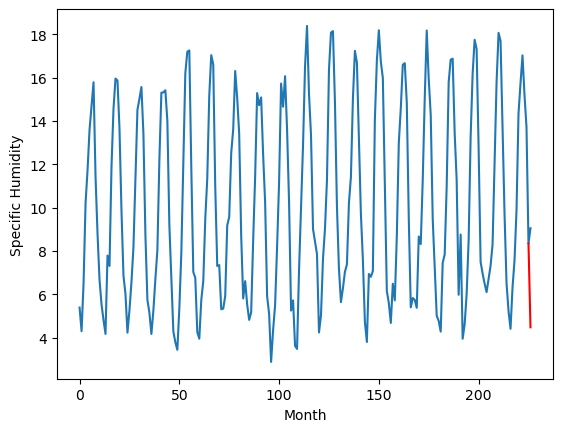

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.17		-0.73


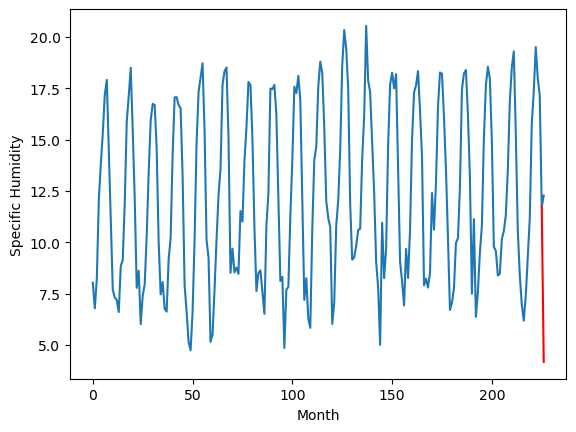

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.82		4.06		-0.76


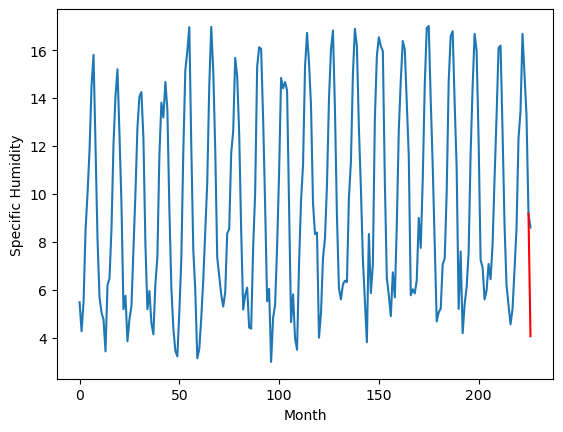

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.21		3.76		-0.45


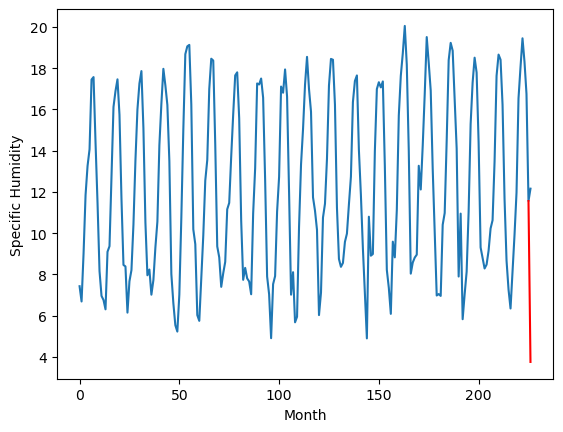

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.32		5.01		-0.31


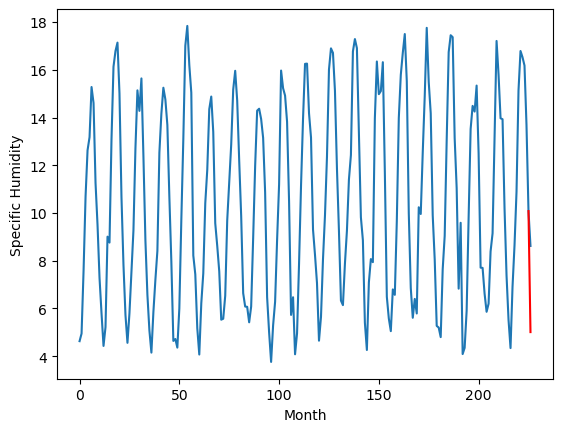

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.42		7.65		0.23


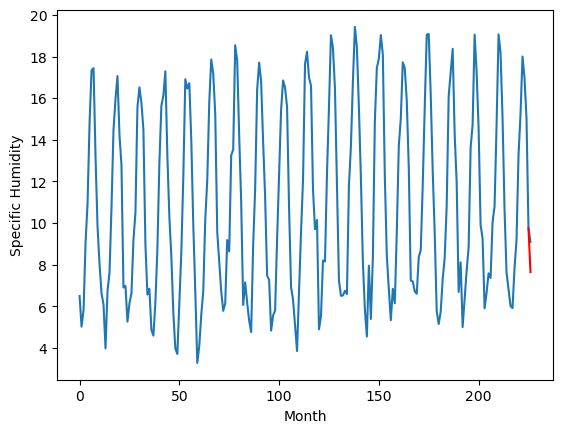

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.33		5.10		-0.23


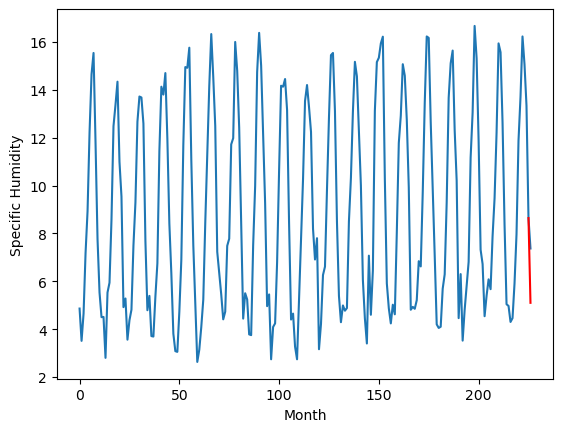

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.12		7.05		-0.07


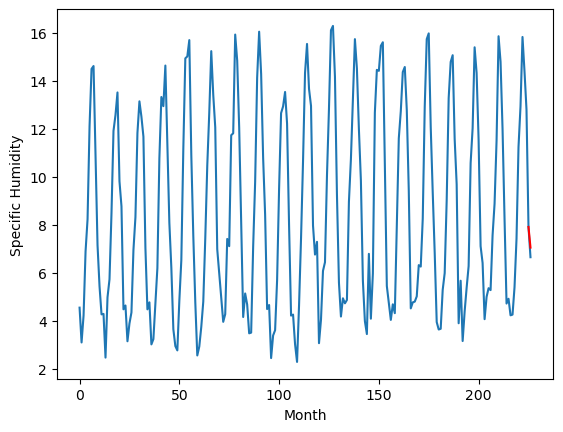

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.40		4.25		-0.15


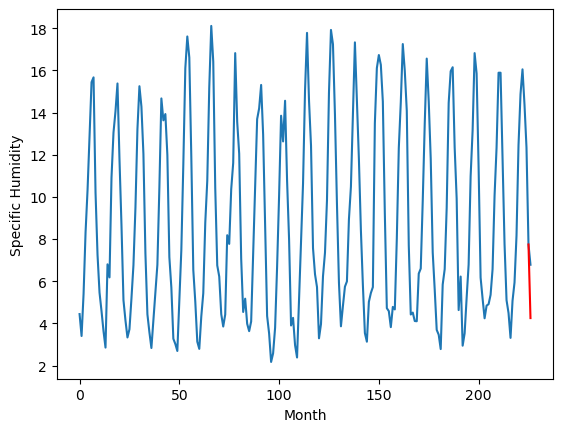

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.17		6.12		-0.05


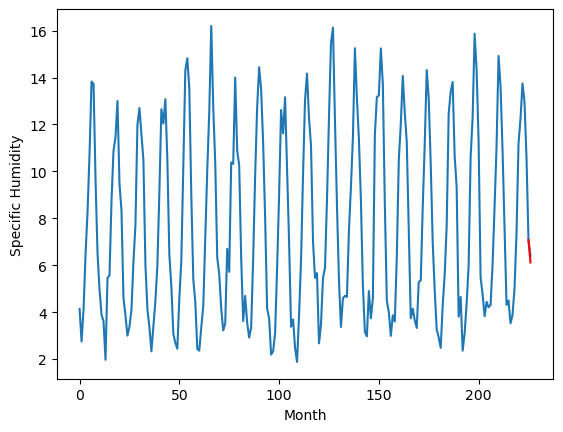

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		4.48		-0.00


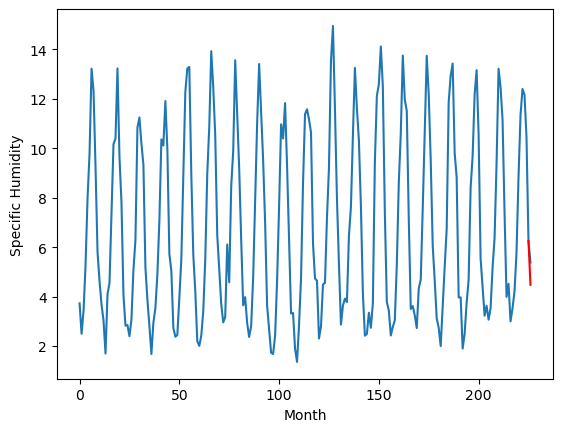

RangeIndex(start=1, stop=12, step=1)
[4.62, 4.899999999999999, 4.820000000000001, 4.209999999999998, 5.32, 7.42, 5.33, 7.119999999999999, 4.4, 6.170000000000001, 4.48]
[4.47975035071373, 4.16975035071373, 4.05975035071373, 3.7597503507137295, 5.0097503507137295, 7.649750350713729, 5.09975035071373, 7.04975035071373, 4.24975035071373, 6.11975035071373, 4.47975035071373]


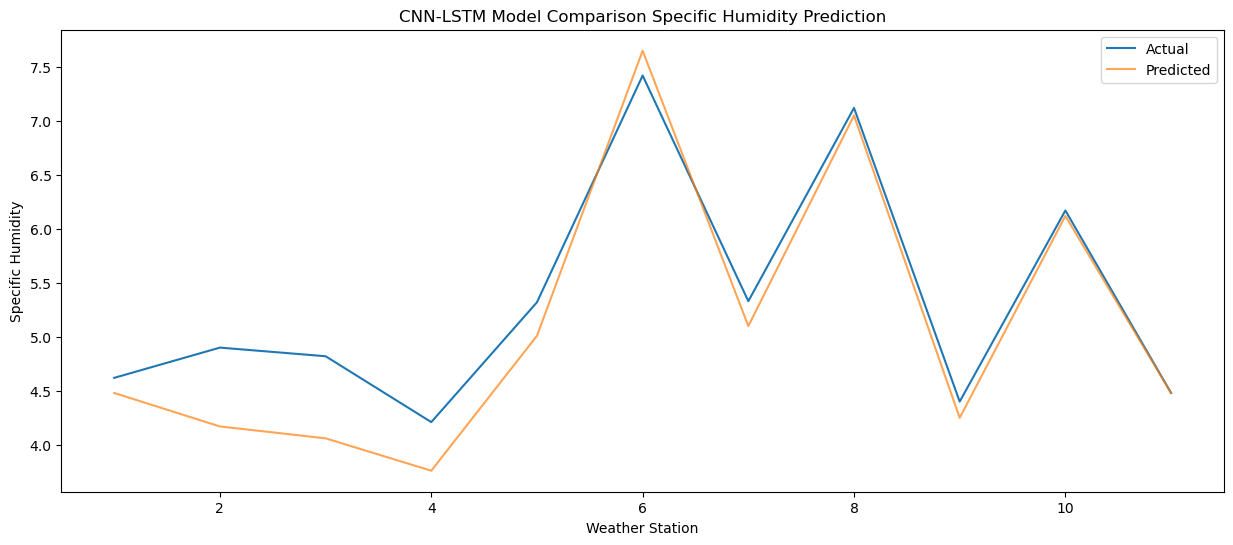

Model: "sequential_501"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_501 (Conv1D)         (None, 1, 256)            504320    
                                                                 
 max_pooling1d_501 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1503 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1002 (LSTM)            (None, 1, 1024)           5246976   
                                                                 
 dropout_1504 (Dropout)      (None, 1, 1024)           0         
                                                                 
 lstm_1003 (LSTM)            (None, 1024)              8392704   
                                                    

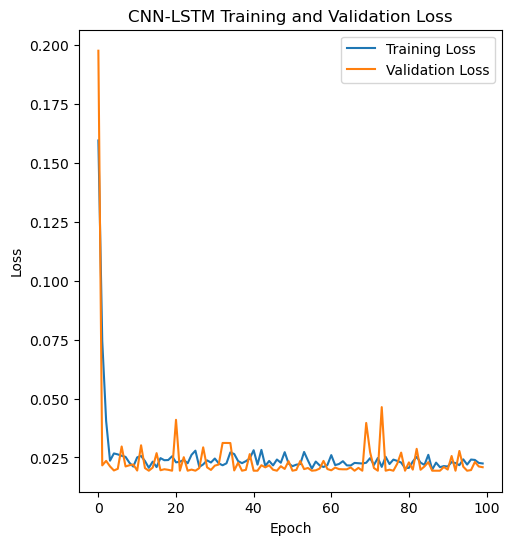

Epoch 1/100
84/84 [==============================] - 39s 216ms/step - loss: 0.2349 - accuracy: 0.0000e+00 - mae: 0.2349 - rmse: 0.2349 - mape: 47.7844 - pearson: nan - val_loss: 0.1011 - val_accuracy: 0.0000e+00 - val_mae: 0.1011 - val_rmse: 0.1011 - val_mape: 20.8804 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 9s 105ms/step - loss: 0.0580 - accuracy: 0.0000e+00 - mae: 0.0580 - rmse: 0.0580 - mape: 11.7201 - pearson: nan - val_loss: 0.0140 - val_accuracy: 0.0000e+00 - val_mae: 0.0140 - val_rmse: 0.0140 - val_mape: 2.8918 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 9s 103ms/step - loss: 0.0439 - accuracy: 0.0000e+00 - mae: 0.0439 - rmse: 0.0439 - mape: 8.8036 - pearson: nan - val_loss: 0.0256 - val_accuracy: 0.0000e+00 - val_mae: 0.0256 - val_rmse: 0.0256 - val_mape: 5.1541 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 9s 102ms/step - loss: 0.0311 - accuracy: 0.0000e+00 - mae: 0.0311 - rmse: 0.0311 - mape:

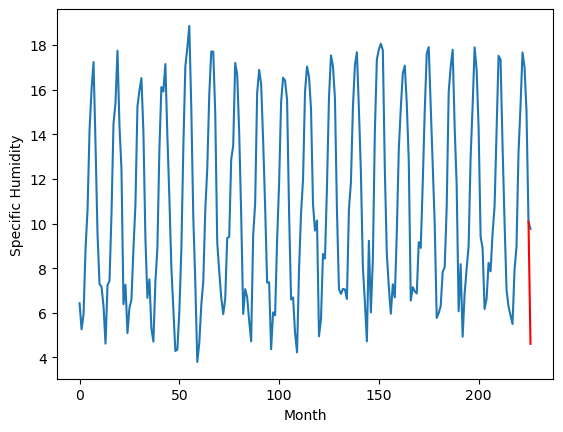

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		4.12		-0.22


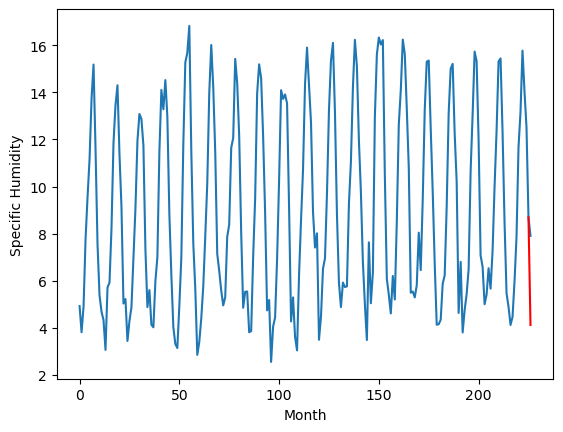

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		2.87		-0.35


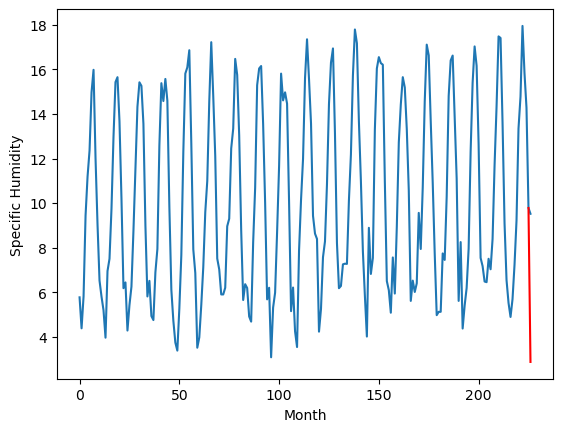

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.17		0.14


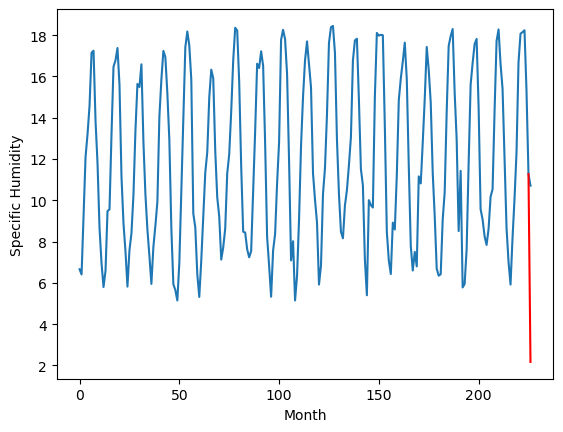

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.23		0.05


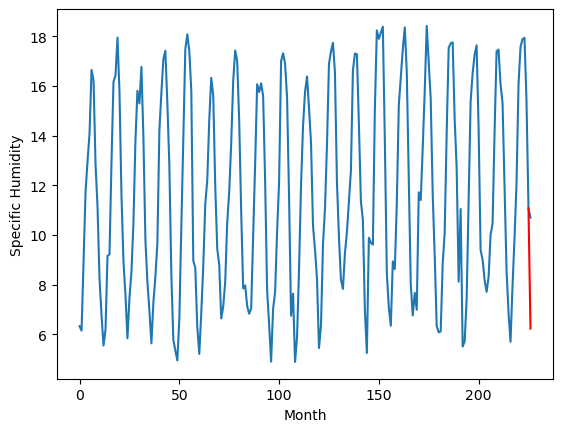

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		4.72		-1.03


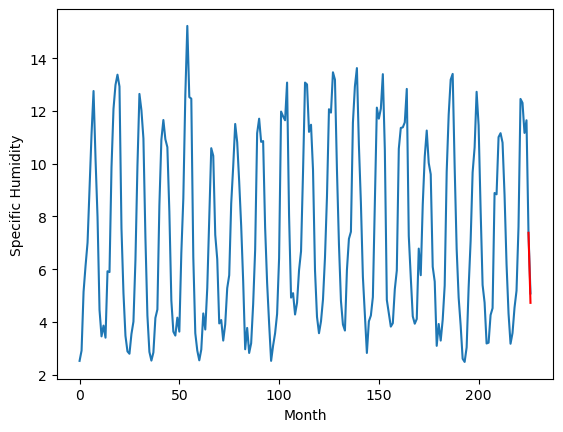

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.57		-0.09


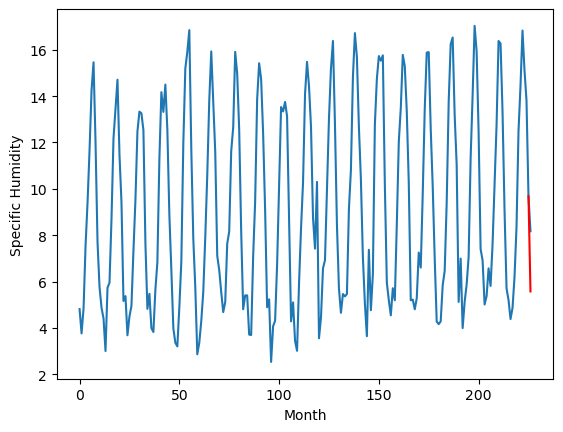

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.46		-0.07


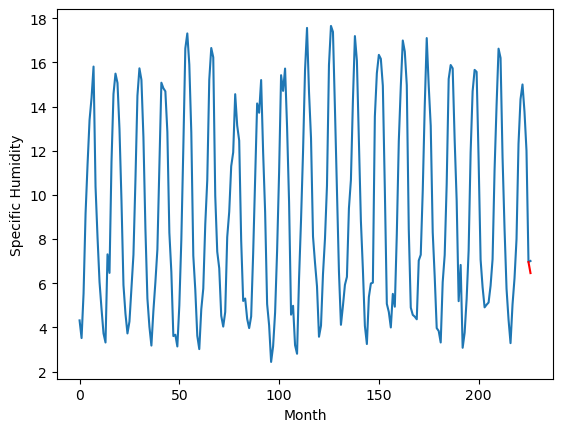

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.13		-0.36


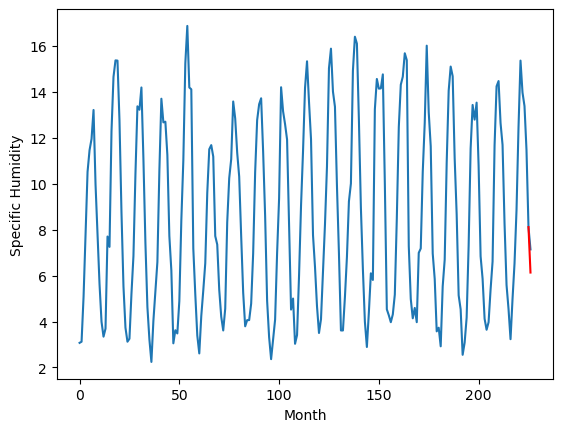

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.32		-0.39


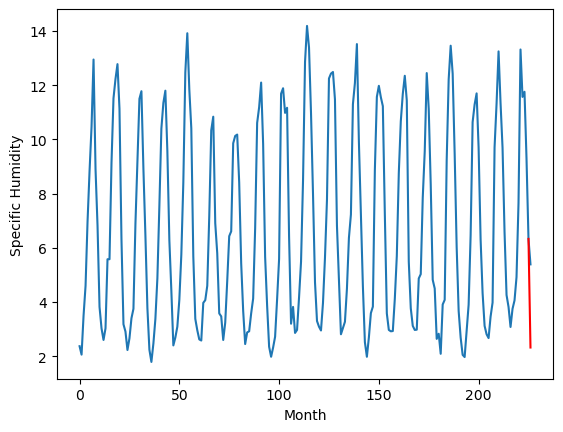

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.61		0.53


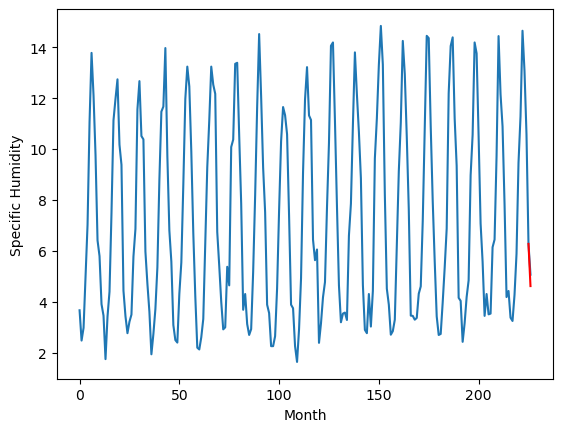

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.611788672804832, 4.121788672804833, 2.8717886728048323, 2.1717886728048326, 6.231788672804832, 4.721788672804832, 5.571788672804832, 6.461788672804833, 6.1317886728048325, 2.3217886728048325, 4.611788672804832]


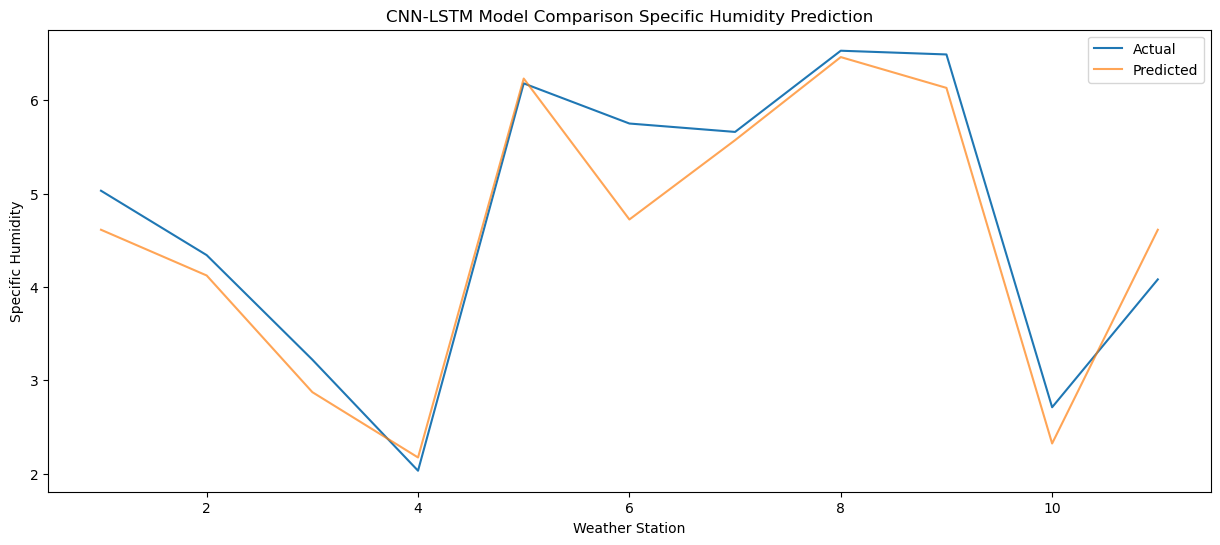

Model: "sequential_502"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_502 (Conv1D)         (None, 1, 256)            504320    
                                                                 
 max_pooling1d_502 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1506 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1004 (LSTM)            (None, 1, 1024)           5246976   
                                                                 
 dropout_1507 (Dropout)      (None, 1, 1024)           0         
                                                                 
 lstm_1005 (LSTM)            (None, 1024)              8392704   
                                                    

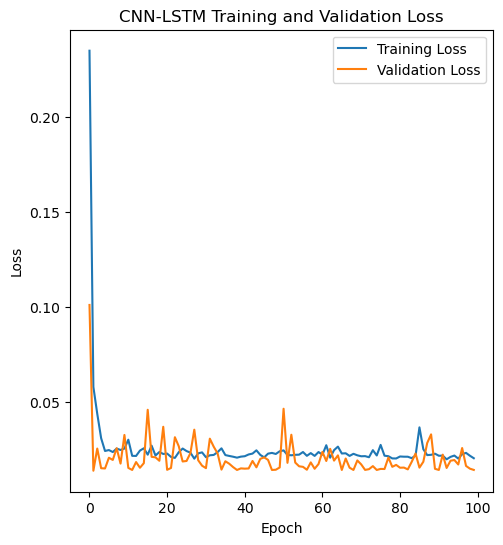

Epoch 1/100
84/84 [==============================] - 29s 182ms/step - loss: 0.1955 - accuracy: 0.0000e+00 - mae: 0.1955 - rmse: 0.1955 - mape: 39.1773 - pearson: nan - val_loss: 0.0791 - val_accuracy: 0.0000e+00 - val_mae: 0.0791 - val_rmse: 0.0791 - val_mape: 16.7075 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 11s 129ms/step - loss: 0.0393 - accuracy: 0.0000e+00 - mae: 0.0393 - rmse: 0.0393 - mape: 7.9238 - pearson: nan - val_loss: 0.0244 - val_accuracy: 0.0000e+00 - val_mae: 0.0244 - val_rmse: 0.0244 - val_mape: 5.2546 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 10s 123ms/step - loss: 0.0237 - accuracy: 0.0000e+00 - mae: 0.0237 - rmse: 0.0237 - mape: 4.7562 - pearson: nan - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mae: 0.0209 - val_rmse: 0.0209 - val_mape: 4.5044 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 88ms/step - loss: 0.0214 - accuracy: 0.0000e+00 - mae: 0.0214 - rmse: 0.0214 - mape:

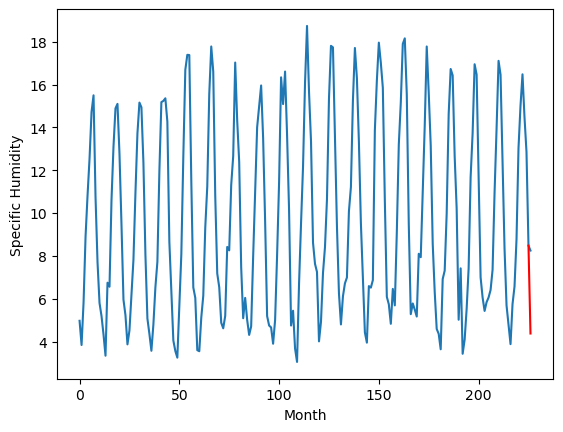

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.65		-0.19


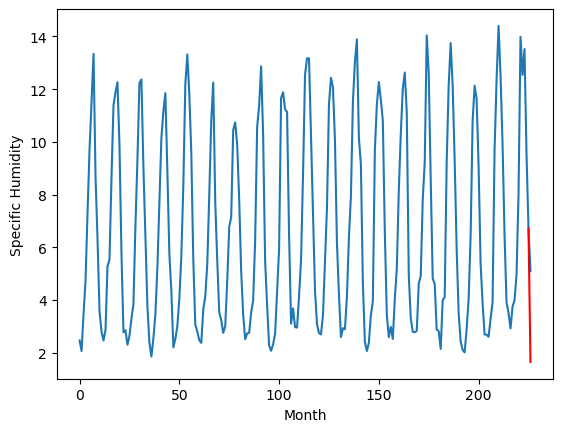

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.80		-0.73


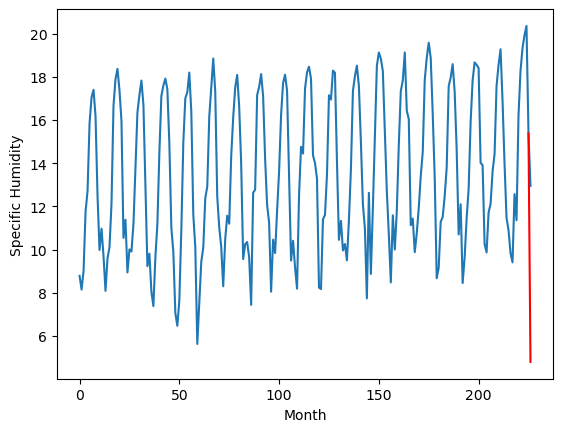

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.82		0.84


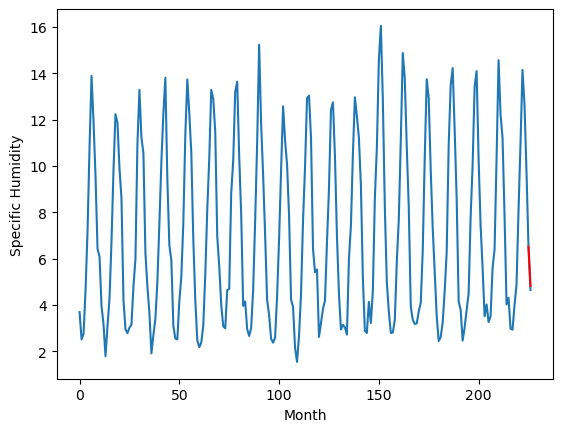

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.73		-0.37


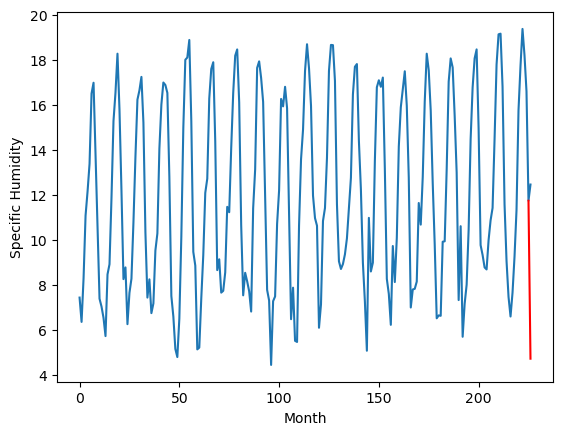

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.22		-0.11


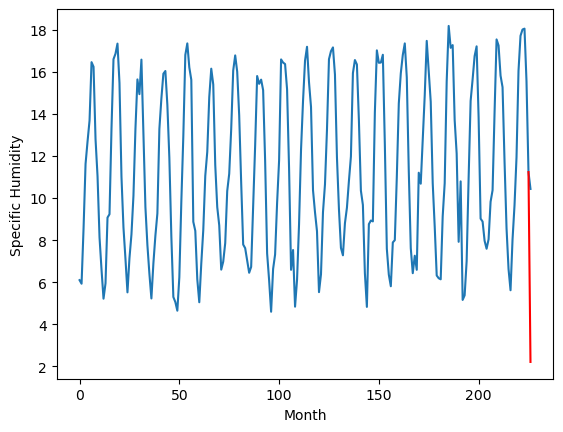

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.54		-0.14


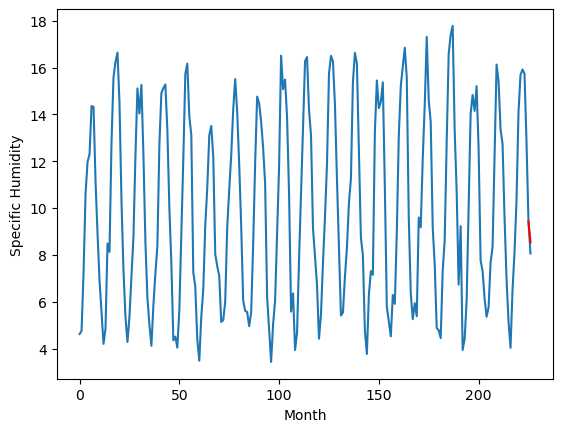

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.45		-0.52


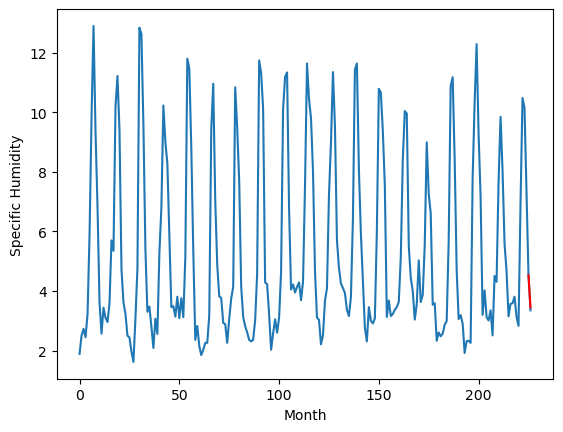

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.20		-1.09


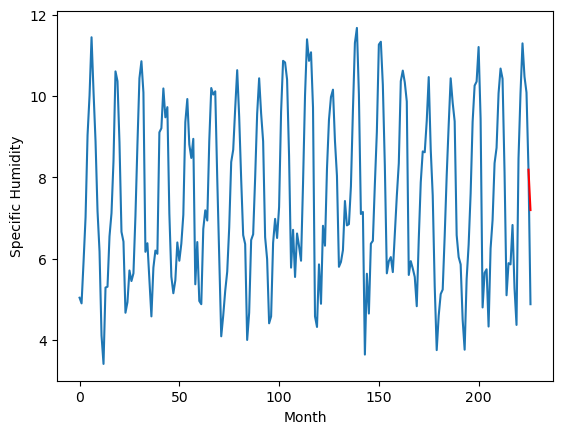

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.86		-0.12


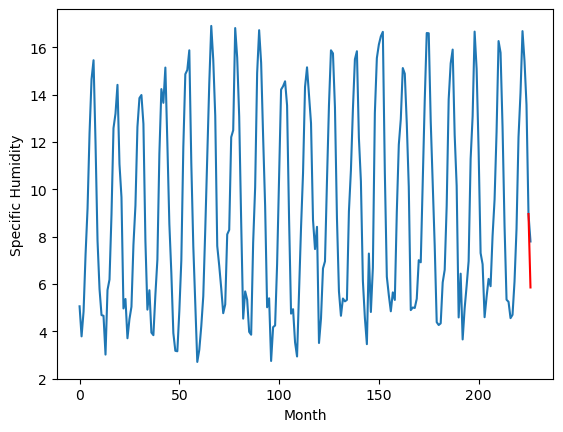

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.38		-0.25


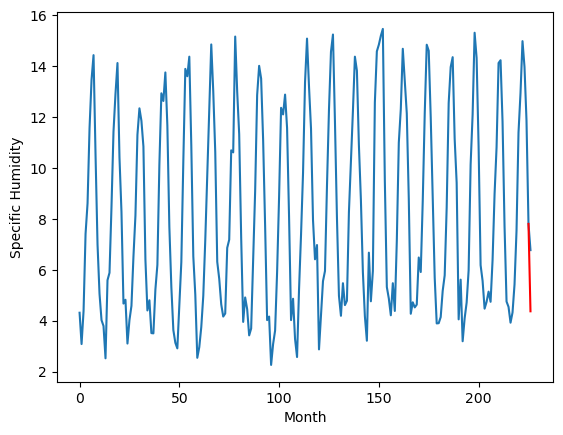

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.377097706198692, 1.6470977061986922, 4.797097706198692, 4.817097706198692, 4.727097706198692, 2.2170977061986923, 8.537097706198692, 3.4470977061986923, 7.197097706198693, 5.857097706198692, 4.377097706198692]


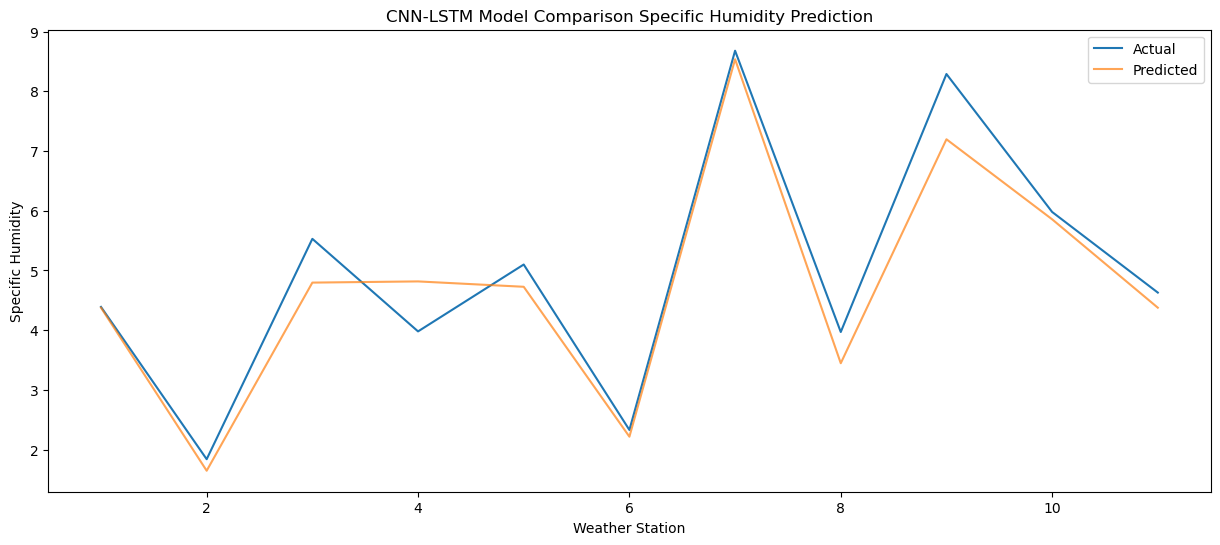

Model: "sequential_503"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_503 (Conv1D)         (None, 1, 256)            504320    
                                                                 
 max_pooling1d_503 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1509 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1006 (LSTM)            (None, 1, 1024)           5246976   
                                                                 
 dropout_1510 (Dropout)      (None, 1, 1024)           0         
                                                                 
 lstm_1007 (LSTM)            (None, 1024)              8392704   
                                                    

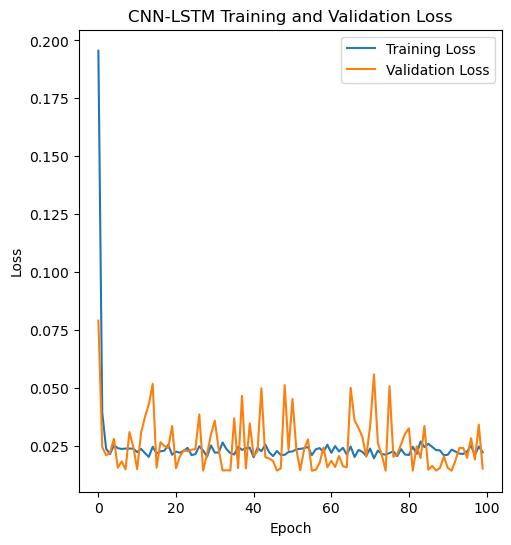

Epoch 1/100
84/84 [==============================] - 25s 157ms/step - loss: 0.1793 - accuracy: 0.0000e+00 - mae: 0.1793 - rmse: 0.1793 - mape: 36.1773 - pearson: nan - val_loss: 0.1213 - val_accuracy: 0.0000e+00 - val_mae: 0.1213 - val_rmse: 0.1213 - val_mape: 24.3244 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 9s 108ms/step - loss: 0.0636 - accuracy: 0.0000e+00 - mae: 0.0636 - rmse: 0.0636 - mape: 12.9663 - pearson: nan - val_loss: 0.0167 - val_accuracy: 0.0000e+00 - val_mae: 0.0167 - val_rmse: 0.0167 - val_mape: 3.1941 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 8s 96ms/step - loss: 0.0485 - accuracy: 0.0000e+00 - mae: 0.0485 - rmse: 0.0485 - mape: 9.7804 - pearson: nan - val_loss: 0.0200 - val_accuracy: 0.0000e+00 - val_mae: 0.0200 - val_rmse: 0.0200 - val_mape: 3.9566 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 7s 82ms/step - loss: 0.0251 - accuracy: 0.0000e+00 - mae: 0.0251 - rmse: 0.0251 - mape: 5

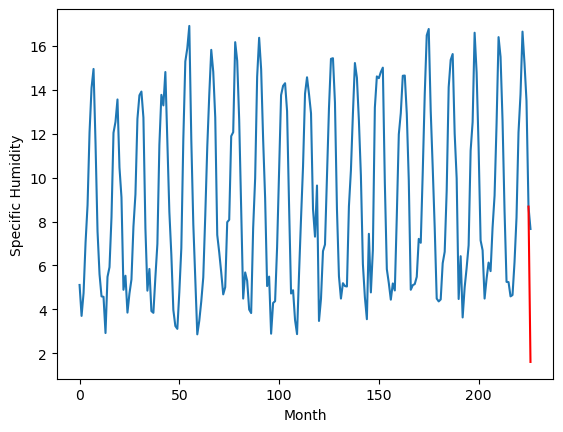

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.64		2.64		0.00


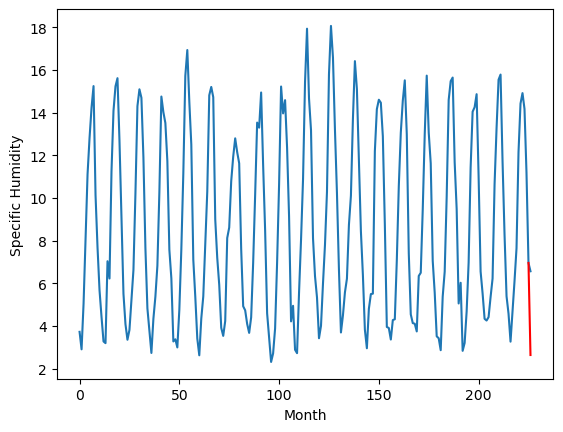

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.37		5.84		-0.53


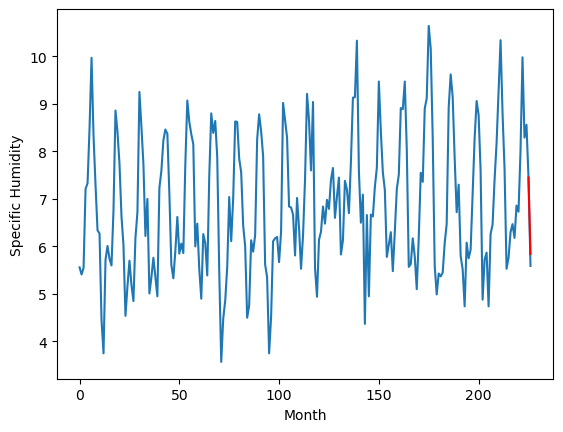

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.44		3.62		0.18


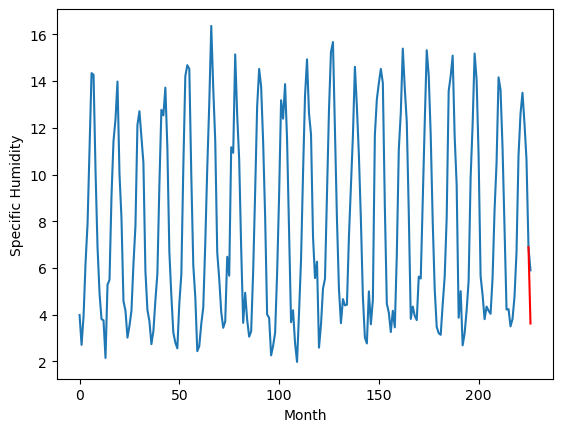

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.91		5.02		0.11


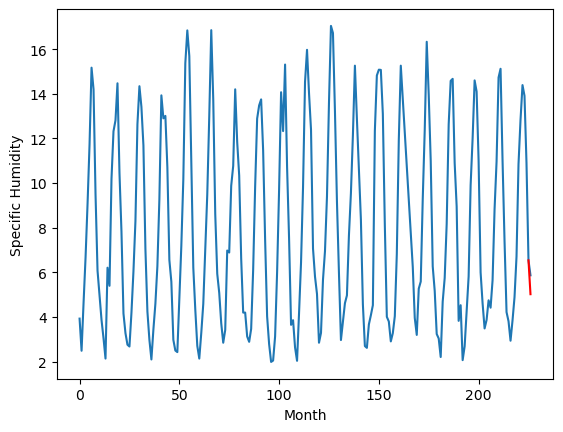

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.42		3.64		0.22


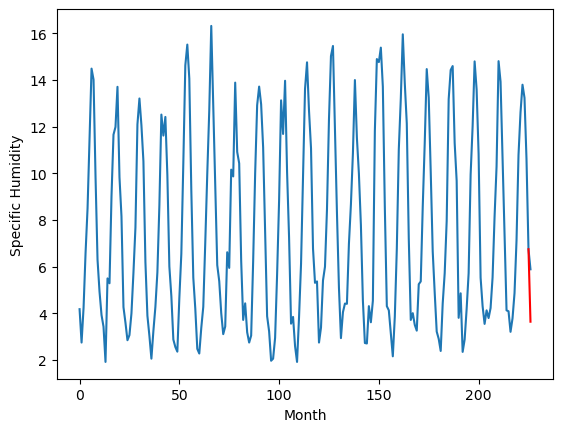

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.73		5.47		-0.26


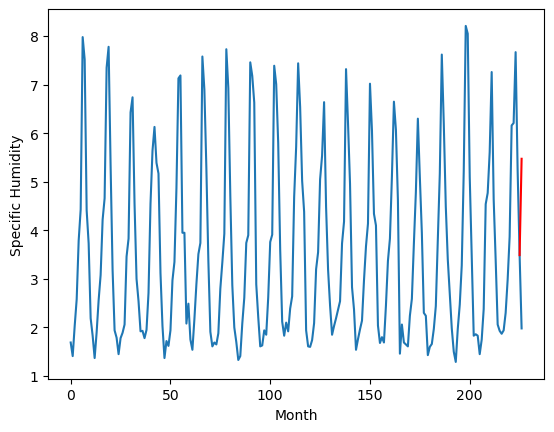

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.80		3.90		-0.90


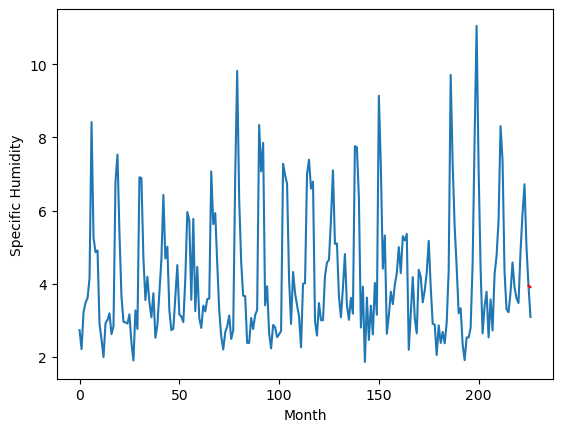

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.60		3.84		-0.76


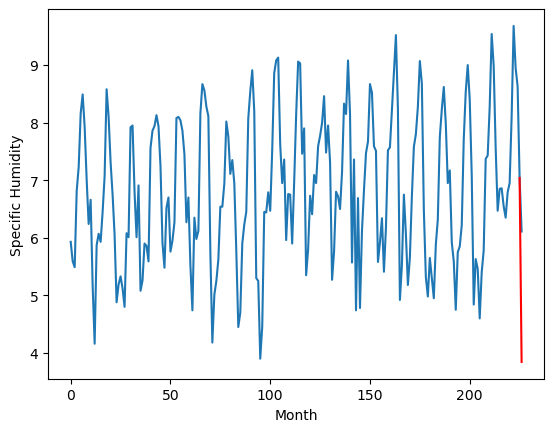

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.09		4.09		1.00


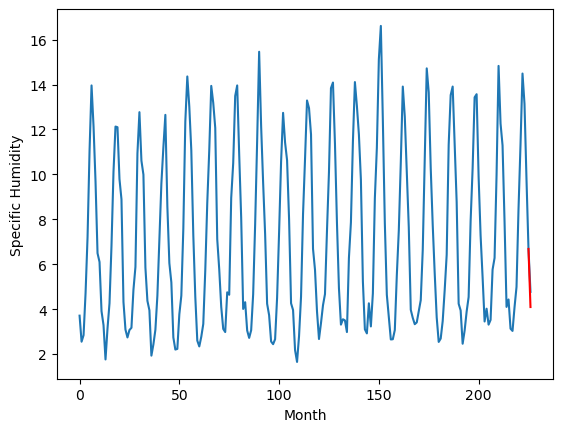

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.00		1.60		0.60


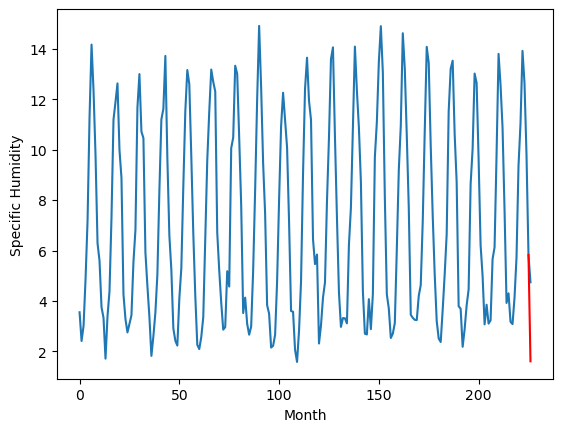

RangeIndex(start=1, stop=12, step=1)
[1.5600000000000005, 2.64, 6.369999999999998, 3.4399999999999995, 4.91, 3.42, 5.73, 4.800000000000001, 4.6, 3.09, 0.9999999999999993]
[1.6039234349131584, 2.6439234349131584, 5.843923434913158, 3.6239234349131584, 5.023923434913159, 3.6439234349131584, 5.473923434913158, 3.9039234349131586, 3.843924403488636, 4.093923434913158, 1.6039234349131584]


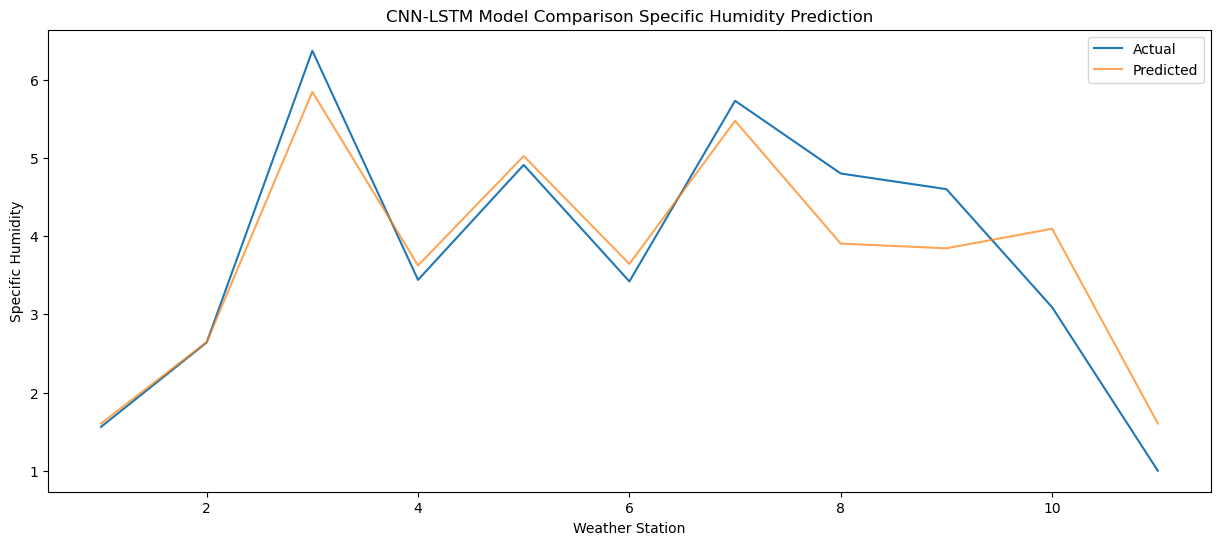

Model: "sequential_504"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_504 (Conv1D)         (None, 1, 256)            504320    
                                                                 
 max_pooling1d_504 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1512 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1008 (LSTM)            (None, 1, 1024)           5246976   
                                                                 
 dropout_1513 (Dropout)      (None, 1, 1024)           0         
                                                                 
 lstm_1009 (LSTM)            (None, 1024)              8392704   
                                                    

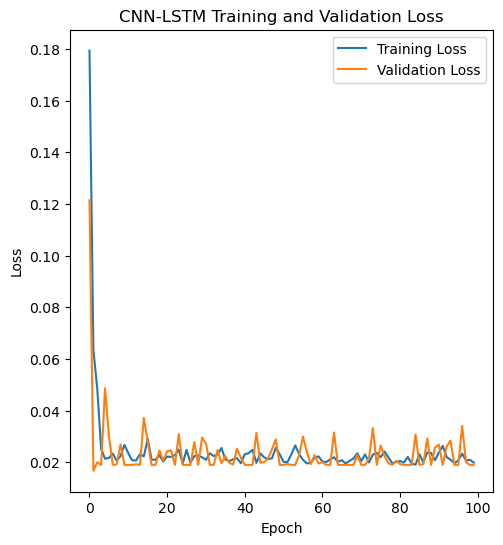

Epoch 1/100
84/84 [==============================] - 17s 82ms/step - loss: 0.1812 - accuracy: 0.0000e+00 - mae: 0.1812 - rmse: 0.1812 - mape: 37.3205 - pearson: nan - val_loss: 0.1365 - val_accuracy: 0.0000e+00 - val_mae: 0.1365 - val_rmse: 0.1365 - val_mape: 27.7137 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0746 - accuracy: 0.0000e+00 - mae: 0.0746 - rmse: 0.0746 - mape: 15.1114 - pearson: nan - val_loss: 0.0511 - val_accuracy: 0.0000e+00 - val_mae: 0.0511 - val_rmse: 0.0511 - val_mape: 10.0444 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 9s 104ms/step - loss: 0.0473 - accuracy: 0.0000e+00 - mae: 0.0473 - rmse: 0.0473 - mape: 9.4766 - pearson: nan - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mae: 0.0208 - val_rmse: 0.0208 - val_mape: 4.1934 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 10s 113ms/step - loss: 0.0338 - accuracy: 0.0000e+00 - mae: 0.0338 - rmse: 0.0338 - mape:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0010070430958316003
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.28840183199671016

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with a CNN-LSTM model,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(n_seq):
        off_s = len(series) - n_seq + i - 1
        off_e = off_s + len(forecasts) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
        plt.xlabel("Month")
        plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100

rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    #print("Forecasts:")
    #print(forecasts)
    #print("Actual:")
    #print(actual)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    print(np.mean(rmse_list))
    print(np.std(rmse_list))

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = [forecasts[j]]
        
        plot_forecasts(series_ws, forecasts_ws, n_test+2, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    # Plotting the results
    plt.figure(figsize=(15, 6))
    plt.plot(results_df['ws'], results_df['Actual'], label='Actual')
    plt.plot(results_df['ws'], results_df['Predicted'], label='Predicted', alpha=0.7)
    plt.title('CNN-LSTM Model Comparison Specific Humidity Prediction')
    plt.xlabel('Weather Station')
    plt.ylabel('Specific Humidity')
    plt.legend()
    plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN-LSTM Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training & validation accuracy
    #plt.subplot(1, 2, 2)
    #plt.plot(history.history['accuracy'], label='Training Accuracy')
    #plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.title('Model Accuracy')
    #plt.xlabel('Epoch')
    #plt.ylabel('Accuracy')
    #plt.legend(['Training', 'Validation'])
    #plt.tight_layout()

# Plot model architecture
filename = "cnnlstm_model_optimized.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [ ]:
from datetime import datetime

# Print out plots of actual and predicted values for each weather station

results = []

# Create a DataFrame for plotting
for j in range(11):
    results.append([j, actual[j][0], forecasts[j][0]])
               
results_df = pd.DataFrame(results)
results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

print(results_df)
            
# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(results_df['Weather_Station'], results_df['Actual'], label='Actual')
plt.plot(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('CNN-LSTM Model Comparison Specific Humidity Prediction')
plt.xlabel('Weather Station')
plt.ylabel('Specific Humidity')
plt.legend()
plt.show()
    
# Plot model architecture
filename = "cnn_lstm_model_optimized_ws_"+str(j)+".png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [ ]:
print(np.mean(rmse_list))
print(np.std(rmse_list))

In [ ]:
print(actual)